# Statistical Analysis <a id='stats'></a>

[Data quality](#qa) <br>
[Behavioral results](#beh) <br>
[Brain graph metrics](#graph) <br>
[Mean FC](#fc) <br>
[Regression analyses](#reg) <br>

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

pd.set_option("display.precision", 3)
sns.set_palette('Set1')

homeDir = os.path.expanduser("~")
homeDir

'/Users/mcmahonmc'

In [2]:
df = pd.read_csv('./data/03_fc_data.csv')
df = df.set_index('subject')
print(df.shape)


modVars = [col for col in df.columns if col.startswith('q_')]
pcVars = [i for i in df.columns if 'pc_' in i and 'dmn_fpn' not in i]
fcVars = [col for col in df.columns if 'fc_' in col]
memVars = [col for col in df.columns if 'acc_' in col or 'rt_c_' in col]
edgeVars = [col for col in df if col.startswith('net')]
pcaVars = ['C1', 'C2', 'C3']
sleepVars = ['actamp', 'actphi', 'sleep_time', 'total_activity', 'sleep_efficiency']

df.head()

(130, 107)


/usr/local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,Group,GroupBin,age,sex,acc_learning,rt_c_learning,acc_learning_log,acc_test_mean,rt_c_test_mean,acc_test_std,...,net_int_edge_19,net_int_edge_20,net_int_edge_21,net_int_edge_22,net_int_edge_23,net_int_edge_24,net_int_mean,C1,C2,C3
subject,,,,,,,,,,,,,,,,,,,,,
30003,Young Adults,0,22.0,Female,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30004,Young Adults,0,27.0,Female,0.917,1263.611,-0.038,0.972,11297.879,0.048,...,0.902,0.518,0.265,0.079,0.082,0.034,0.166,0.168,-0.199,-0.113
30008,Young Adults,0,18.0,Female,0.944,1674.861,-0.025,0.944,11504.639,0.048,...,0.350,-0.051,0.715,0.176,0.100,0.201,0.185,0.020,0.117,-0.165
30009,Young Adults,0,25.0,Female,0.972,1568.694,-0.012,0.972,11405.333,0.048,...,0.247,0.266,0.087,0.601,0.353,0.064,0.096,0.975,-0.306,0.100
30012,Young Adults,0,30.0,Male,0.917,2146.417,-0.038,0.806,11539.750,0.127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820,-0.199,-0.186


## Data quality <a id='qa'></a>

In [3]:
print(df.shape)
df = df.dropna(subset=['acc_test_mean'])
print(df.shape)
df = df[(df['acc_learning'] > 0.33)]
print(df.shape)
df = df[(df['acc_test_mean'] > 0.56)]
print(df.shape)
df = df[(~df['C1'].isna())] # these are participants with poor quality actigraphy data, determined from ML project
print(df.shape)

(130, 107)
(114, 107)
(112, 107)
(100, 107)
(92, 107)


In [4]:
df[['actamp', 'actphi', 'q_dmnfpn_cue', 'acc_test_mean']].isna().sum()

actamp            2
actphi            2
q_dmnfpn_cue     25
acc_test_mean     0
dtype: int64

In [5]:
ya = df[df['Group'] == 'Young Adults']
ya = ya.fillna(ya.mean())

oa = df[df['Group'] == 'Older Adults']
oa = oa.fillna(oa.mean())

dfFill = pd.concat((ya, oa))
print(df.shape)
dfFill.head()

(92, 107)


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_67958/852004413.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ya = ya.fillna(ya.mean())
/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_67958/852004413.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  oa = oa.fillna(oa.mean())


,Group,GroupBin,age,sex,acc_learning,rt_c_learning,acc_learning_log,acc_test_mean,rt_c_test_mean,acc_test_std,...,net_int_edge_19,net_int_edge_20,net_int_edge_21,net_int_edge_22,net_int_edge_23,net_int_edge_24,net_int_mean,C1,C2,C3
subject,,,,,,,,,,,,,,,,,,,,,
30004,Young Adults,0,27.0,Female,0.917,1263.611,-0.038,0.972,11297.879,0.048,...,0.902,0.518,0.265,0.079,0.082,0.034,0.166,0.168,-0.199,-0.113
30008,Young Adults,0,18.0,Female,0.944,1674.861,-0.025,0.944,11504.639,0.048,...,0.350,-0.051,0.715,0.176,0.100,0.201,0.185,0.020,0.117,-0.165
30009,Young Adults,0,25.0,Female,0.972,1568.694,-0.012,0.972,11405.333,0.048,...,0.247,0.266,0.087,0.601,0.353,0.064,0.096,0.975,-0.306,0.100
30012,Young Adults,0,30.0,Male,0.917,2146.417,-0.038,0.806,11539.750,0.127,...,0.461,0.281,0.282,0.228,0.342,0.207,0.190,0.820,-0.199,-0.186
30015,Young Adults,0,26.0,Male,0.972,2064.250,-0.012,0.889,11690.604,0.048,...,0.170,0.281,-0.048,0.396,0.034,0.199,0.149,0.160,-0.288,0.026


In [6]:
df.acc_test_mean.min()

0.638888888888889

## Behavioral results <a id='beh'></a>

### Task

In [7]:
behtable = df[['Group'] + [c for c in memVars if 'learning' in c or 'mean' in c]].groupby('Group').describe().T.round(3)[['Young Adults', 'Older Adults']]
behtable.to_latex('./results/behresults.tex', index=True)
behtable

Group                    Young Adults  Older Adults
acc_learning      count        47.000        45.000
                  mean          0.909         0.838
                  std           0.136         0.143
                  min           0.333         0.417
                  25%           0.875         0.806
                  50%           0.944         0.889
                  75%           1.000         0.944
                  max           1.000         1.000
rt_c_learning     count        47.000        45.000
                  mean       1828.900      2569.343
                  std         499.434      1022.356
                  min         735.417       396.750
                  25%        1468.056      1888.500
                  50%        1794.611      2383.222
                  75%        2117.639      3097.333
                  max        3693.194      6417.333
acc_learning_log  count        47.000        45.000
                  mean         -0.049        -0.084
                  std           0.089         0.086
                  min          -0.477        -0.380
                  25%          -0.058        -0.094
                  50%          -0.025        -0.051
                  75%           0.000        -0.025
                  max           0.000         0.000
acc_test_mean     count        47.000        45.000
                  mean          0.908         0.848
                  std           0.099         0.096
                  min           0.667         0.639
                  25%           0.875         0.778
                  50%           0.944         0.861
                  75%           0.972         0.917
                  max           1.000         1.000
rt_c_test_mean    count        47.000        45.000
                  mean      11474.970     11789.461
                  std         197.735       239.543
                  min       11063.972     11210.629
                  25%       11325.345     11604.321
                  50%       11481.222     11803.336
                  75%       11577.420     11935.972
                  max       11955.700     12314.625
acc_test_mean_log count        47.000        45.000
                  mean         -0.045        -0.075
                  std           0.051         0.050
                  min          -0.176        -0.195
                  25%          -0.058        -0.109
                  50%          -0.025        -0.065
                  75%          -0.012        -0.038
                  max           0.000         0.000

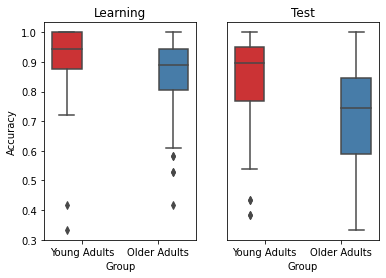

In [8]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='acc_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='acc_test_mean', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/accuracy.png', dpi=300, bbox_inches='tight')

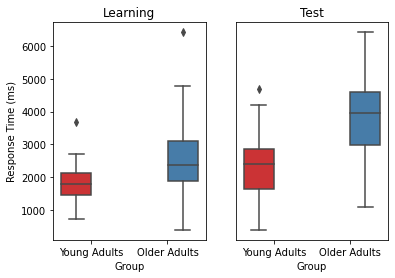

In [9]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='rt_c_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Response Time (ms)'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='rt_c_test_mean', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rtc.png', dpi=300, bbox_inches='tight')

In [10]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_learning'].dropna(), df[df['Group'] == "Older Adults"]['acc_learning'].dropna())

Ttest_indResult(statistic=2.4292642562573286, pvalue=0.017116264267879055)

In [11]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_learning'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_learning'].dropna())

Ttest_indResult(statistic=-4.4430249846017436, pvalue=2.5184729093114565e-05)

In [12]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_test_mean'].dropna(), df[df['Group'] == "Older Adults"]['acc_test_mean'].dropna())

Ttest_indResult(statistic=2.920635265798123, pvalue=0.00441453041139037)

In [13]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_test_mean'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_test_mean'].dropna())

Ttest_indResult(statistic=-6.879887785097898, pvalue=7.716462241451917e-10)

,n,r,CI95%,p-val,BF10,power
pearson,92,-0.565,"[-0.69, -0.41]",4.573e-09,2.864e+06,1.0


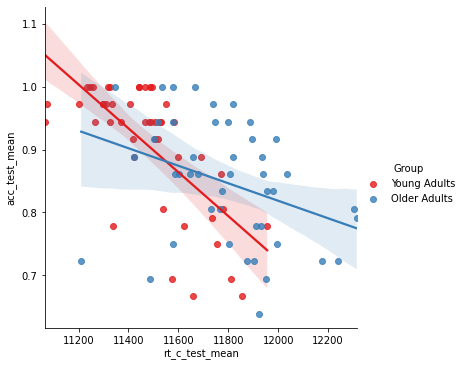

In [14]:
sns.lmplot(data=df, x='rt_c_test_mean', y='acc_test_mean', hue='Group')
pg.corr(df['acc_test_mean'], df['rt_c_test_mean'])

### RAR/Sleep

In [15]:
stats.ttest_ind(df[df['sex'] == "Male"]['actamp'].dropna(), df[df['sex'] == "Female"]['actamp'].dropna())

Ttest_indResult(statistic=-1.5860914668280197, pvalue=0.11630559699185643)

In [16]:
stats.ttest_ind(df[df['sex'] == "Male"]['actphi'].dropna(), df[df['sex'] == "Female"]['actphi'].dropna())

Ttest_indResult(statistic=1.2543208048233379, pvalue=0.2130469268396735)

In [17]:
pg.corr(df['actamp'], df['sleep_time'])

,n,r,CI95%,p-val,BF10,power
pearson,90,0.149,"[-0.06, 0.35]",0.161,0.346,0.29


In [18]:
pg.corr(df['actamp'], df['sleep_efficiency'])

,n,r,CI95%,p-val,BF10,power
pearson,90,0.242,"[0.04, 0.43]",0.021,1.789,0.64


In [19]:
pg.corr(df['actamp'], df['total_activity'])

,n,r,CI95%,p-val,BF10,power
pearson,90,0.353,"[0.16, 0.52]",6.372e-04,40.885,0.933


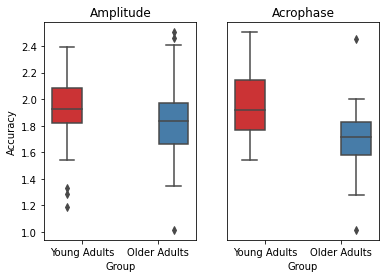

In [20]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='actamp', hue='Group', ax=axes[0]).set(title='Amplitude');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='actphi', hue='Group', ax=axes[1]).set(title='Acrophase');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('./results/rar.png', dpi=300, bbox_inches='tight')

In [21]:
df[['actamp', 'actphi', 'sleep_time', 'total_activity', 'sleep_efficiency', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
actamp,1.834,1.914
actphi,14.929,16.467
sleep_time,405.339,387.896
total_activity,253785.159,315614.822
sleep_efficiency,80.793,82.318


In [22]:
df[['actamp', 'actphi', 'sleep_time', 'total_activity', 'sleep_efficiency', 'Group']].groupby('Group').std().T

Group,Older Adults,Young Adults
actamp,0.306,0.261
actphi,1.488,1.453
sleep_time,79.954,55.096
total_activity,74766.345,110695.765
sleep_efficiency,9.681,5.834


In [23]:
var='actamp'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=1.354528998381597, pvalue=0.17903532349601148)

In [24]:
var='actphi'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=4.957636874439705, pvalue=3.438096778138025e-06)

In [25]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['sleep_time'].dropna(), df[df['Group'] == "Older Adults"]['sleep_time'].dropna())


Ttest_indResult(statistic=-1.222965093738663, pvalue=0.22453558543240779)

In [26]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['total_activity'].dropna(), df[df['Group'] == "Older Adults"]['total_activity'].dropna())



Ttest_indResult(statistic=3.125631720074818, pvalue=0.00238878394225707)

In [27]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['sleep_efficiency'].dropna(), df[df['Group'] == "Older Adults"]['sleep_efficiency'].dropna())

Ttest_indResult(statistic=0.9195514924225325, pvalue=0.3602652395033258)

## Global brain network metrics <a id='graph'></a>

In [28]:
df[['q_dmnfpn_cue', 'q_dmnfpn_rest', 'pc_dmnfpn_cue', 'q_global_cue', 'q_global_rest', 'pc_global_cue', 'Group']].groupby('Group').mean().T

Group,Older Adults,Young Adults
q_dmnfpn_cue,0.140,0.148
q_dmnfpn_rest,0.143,0.117
pc_dmnfpn_cue,0.216,0.184
q_global_cue,0.305,0.365
q_global_rest,0.368,0.371
pc_global_cue,0.424,0.420


In [29]:
df[['Group'] + fcVars].groupby('Group').mean().T

Group,Older Adults,Young Adults
dmnfc_cue,0.362,0.331
fpnfc_cue,0.471,0.428
dmnfpnfc_cue,0.284,0.212
hcdmnfc_cue,0.132,0.144
hcfpnfc_cue,0.089,0.047
dmnfc_match,0.310,0.311
fpnfc_match,0.378,0.382
dmnfpnfc_match,0.239,0.194
hcdmnfc_match,0.166,0.151
hcfpnfc_match,0.121,0.037


In [30]:
var = 'hcdmnfc_cue'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=0.3402308651243869, pvalue=0.7347470881860302)

In [31]:
var = 'hcfpnfc_cue'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.0718951905999439, pvalue=0.28761300676937906)

In [32]:
var = 'dmnfpnfc_cue'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-2.2789881057966874, pvalue=0.025860029373125683)

In [33]:
var = 'dmnfc_cue'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.183753934753341, pvalue=0.2406933741079501)

In [34]:
var = 'fpnfc_cue'
stats.ttest_ind(df[df['Group'] == "Young Adults"][var].dropna(), df[df['Group'] == "Older Adults"][var].dropna())

Ttest_indResult(statistic=-1.3957163208392434, pvalue=0.16740828385144596)

In [35]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.9882402575946352, pvalue=0.05127751950797871)

In [36]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_dmnfpn_cue'].dropna(), df[df['Group'] == "Older Adults"]['pc_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.6283258357354193, pvalue=0.010629591460048505)

In [37]:

stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.5893202500741515, pvalue=2.008524498479919e-05)

In [38]:
dfl = df.reset_index()[['subject', 'Group'] + modVars]
dfl = pd.wide_to_long(dfl, ["q_global", 'q_power', "q_dmnfpn"], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl.head()

,subject,Group,condition,q_global,q_power,q_dmnfpn
0,30004,Young Adults,cue,0.398,0.398,0.242
1,30004,Young Adults,diff,0.015,NaN,-0.054
2,30004,Young Adults,match,0.382,0.382,0.158
3,30004,Young Adults,mismatch,0.301,0.301,0.179
4,30004,Young Adults,rest,0.413,NaN,0.188


Text(0.5, 0, 'Condition')

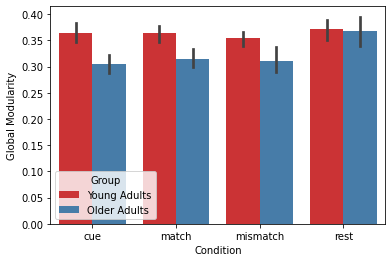

In [39]:
dfp = dfl[dfl['condition'] != 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

Text(0.5, 0, 'Condition')

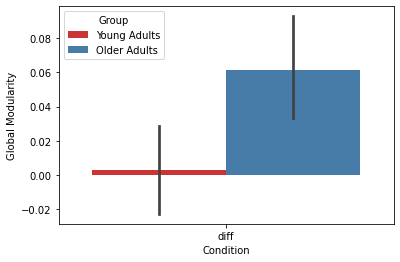

In [40]:
dfp = dfl[dfl['condition'] == 'diff']
sns.barplot(x=dfp['condition'], y=dfp['q_global'], hue=dfp['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

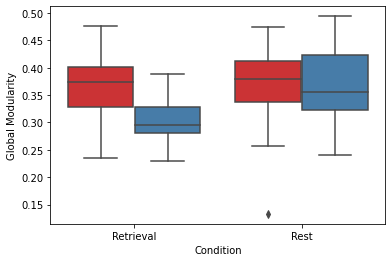

In [41]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.get_legend().remove()
plt.savefig('./results/globalmod_cond.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Condition')

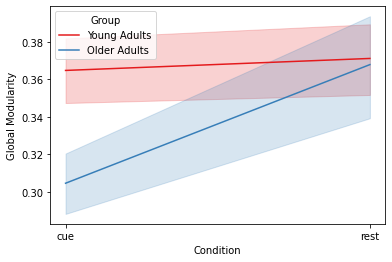

In [42]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_global'], hue=dfbar['Group'])
plt.ylabel('Global Modularity'); plt.xlabel('Condition')

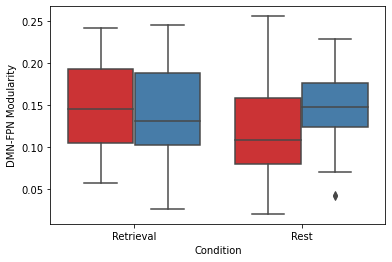

In [43]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
ax = sns.boxplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.get_legend().remove()
plt.savefig('./results/dmnfpnmod_cond.png', dpi=300, bbox_inches='tight')

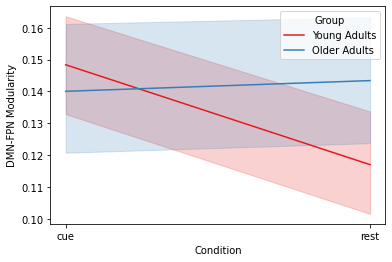

In [44]:
dfbar = dfl[(dfl['condition'].isin(['rest', 'cue']))]
sns.lineplot(x=dfbar['condition'], y=dfbar['q_dmnfpn'], hue=dfbar['Group'])
plt.ylabel('DMN-FPN Modularity'); plt.xlabel('Condition');

DMN-FPN Modularity

In [45]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.6313428379301895, pvalue=0.5300303942142928)

In [46]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna())

Ttest_indResult(statistic=-1.9882402575946352, pvalue=0.05127751950797871)

In [47]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_dmnfpn_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['pc_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.6283258357354193, pvalue=0.010629591460048505)

In [48]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_dmnfpn_rest'].dropna(), 
                df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=-2.7416949840297784, pvalue=0.0075572709745020525)

In [49]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_dmnfpn_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna())

Ttest_indResult(statistic=0.22534703150703217, pvalue=0.8226863033935394)

Global modularity

In [50]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_global_rest'].dropna())

Ttest_indResult(statistic=0.19050641560626588, pvalue=0.849544916724119)

In [51]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.5893202500741515, pvalue=2.008524498479919e-05)

In [52]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_global_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['pc_global_cue'].dropna())

Ttest_indResult(statistic=-0.06302882500745907, pvalue=0.9499312125457662)

In [53]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_rest'].dropna(), 
                df[df['Group'] == "Young Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=0.48068984812540366, pvalue=0.6320327566919914)

In [54]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Older Adults"]['q_global_rest'].dropna(), 
                df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=3.853631393810381, pvalue=0.00035194395986807203)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


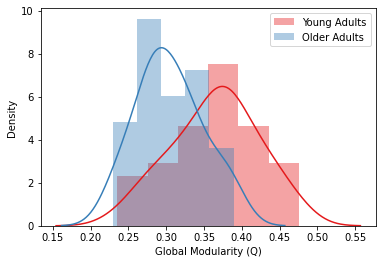

In [55]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Modularity (Q)')
plt.legend()
plt.savefig('./results/global_modularity.png', dpi=300, bbox_inches='tight')

In [56]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global_cue'].dropna(), df[df['Group'] == "Older Adults"]['q_global_cue'].dropna())

Ttest_indResult(statistic=4.5893202500741515, pvalue=2.008524498479919e-05)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


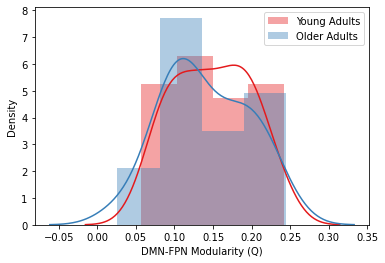

In [57]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_dmnfpn_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_dmnfpn_cue'].dropna(), label = 'Older Adults')
plt.xlabel('DMN-FPN Modularity (Q)')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


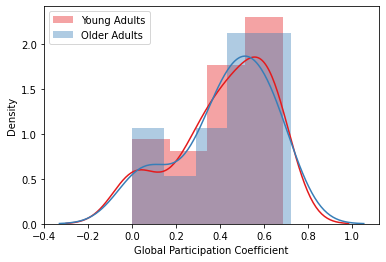

In [58]:
sns.distplot(df[df['Group'] == "Young Adults"]['pc_global_cue'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['pc_global_cue'].dropna(), label = 'Older Adults')
plt.xlabel('Global Participation Coefficient')
plt.legend()
plt.savefig('./results/global_pc.png', dpi=300, bbox_inches='tight')

In [59]:
dfl = df.reset_index()[['subject', 'Group'] + pcVars[2:]]
dfl = pd.wide_to_long(dfl, ['pc_global', 'pc_dmn', 'pc_fpn', 'pc_dmnfpn'], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl

,subject,Group,condition,pc_power_match,pc_power_mismatch,pc_power_cue,pc_global,pc_dmn,pc_fpn,pc_dmnfpn
0,30004,Young Adults,cue,0.572,0.281,0.421,NaN,0.439,0.293,0.132
1,30004,Young Adults,match,0.572,0.281,0.421,NaN,0.414,0.413,0.185
2,30004,Young Adults,mismatch,0.572,0.281,0.421,0.281,0.161,0.358,0.191
3,30008,Young Adults,cue,0.069,0.636,0.670,NaN,0.432,0.289,0.152
4,30008,Young Adults,match,0.069,0.636,0.670,NaN,0.333,0.447,0.182
...,...,...,...,...,...,...,...,...,...,...
271,40876,Older Adults,match,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,40876,Older Adults,mismatch,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,40878,Older Adults,cue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,40878,Older Adults,match,NaN,NaN,NaN,NaN,NaN,NaN,NaN


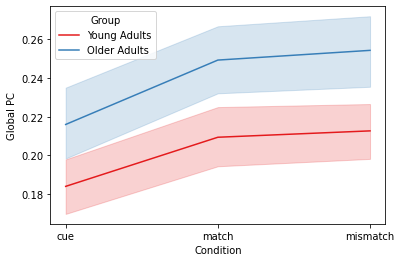

In [60]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('Global PC'); plt.xlabel('Condition');

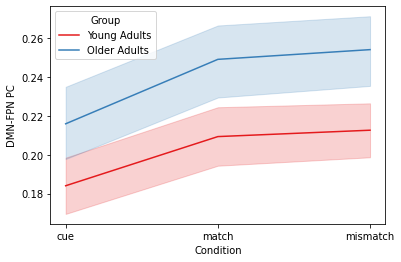

In [61]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmnfpn'], hue=dfl['Group'])
plt.ylabel('DMN-FPN PC'); plt.xlabel('Condition');

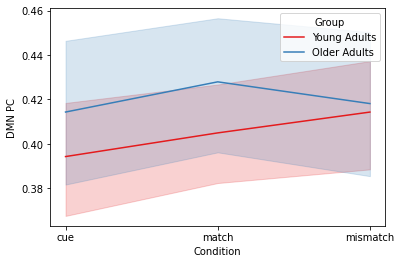

In [62]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_dmn'], hue=dfl['Group'])
plt.ylabel('DMN PC'); plt.xlabel('Condition');

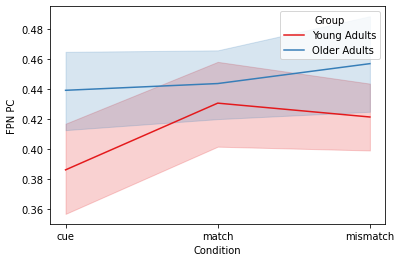

In [63]:
sns.lineplot(x=dfl['condition'], y=dfl['pc_fpn'], hue=dfl['Group'])
plt.ylabel('FPN PC'); plt.xlabel('Condition');

## Mean FC <a id='fc'></a>

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


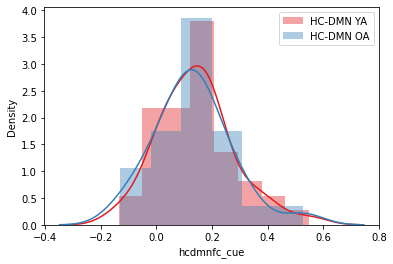

In [64]:
sns.distplot(df[df['Group'] == "Young Adults"]['hcdmnfc_cue'], label = 'HC-DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hcdmnfc_cue'], label = 'HC-DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


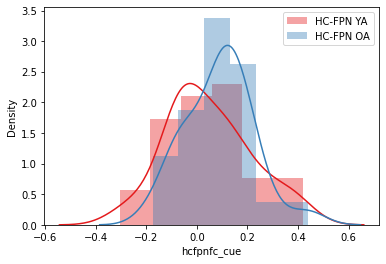

In [65]:
sns.distplot(df[df['Group'] == "Young Adults"]['hcfpnfc_cue'], label = 'HC-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hcfpnfc_cue'], label = 'HC-FPN OA')
plt.legend()

In [66]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['hcfpnfc_cue'].dropna(), df[df['Group'] == "Older Adults"]['hcfpnfc_cue'].dropna(), equal_var=True)

Ttest_indResult(statistic=-1.0718951905999439, pvalue=0.28761300676937906)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


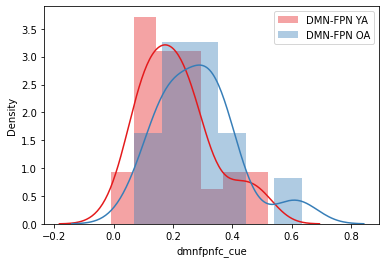

In [67]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmnfpnfc_cue'], label = 'DMN-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmnfpnfc_cue'], label = 'DMN-FPN OA')
plt.legend()

In [68]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['dmnfpnfc_cue'].dropna(), 
                df[df['Group'] == "Older Adults"]['dmnfpnfc_cue'].dropna(), equal_var=True)

Ttest_indResult(statistic=-2.2789881057966874, pvalue=0.025860029373125683)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


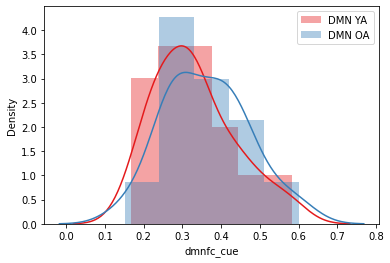

In [69]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmnfc_cue'], label = 'DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmnfc_cue'], label = 'DMN OA')
plt.legend()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


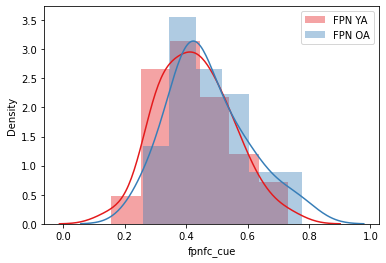

In [70]:
sns.distplot(df[df['Group'] == "Young Adults"]['fpnfc_cue'], label = 'FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['fpnfc_cue'], label = 'FPN OA')
plt.legend()

## Regression analyses <a id='reg'></a>

In [71]:
from scipy.stats.mstats import zscore

convert_dict = {'Group': str,
                'sex': str
               }
  
df = df.astype(convert_dict)

print(df.shape)

(92, 107)


In [72]:
# ya = ya.select_dtypes(include=object).join(ya.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = ya.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# yaCl = ya[filtered_entries]
# yaCl.shape

In [73]:
# oa = oa.select_dtypes(include=object).join(oa.select_dtypes(include=[np.number]).apply(stats.zscore))
# abs_z_scores = oa.select_dtypes(include=[np.number]).abs()
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# oaCl = oa[filtered_entries]
# oaCl.shape

In [74]:
df.groupby(['Group'])['age', 'hcdmnfc_cue', 'hcfpnfc_cue', 'q_global_cue'].describe()

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_67958/1327449660.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Group'])['age', 'hcdmnfc_cue', 'hcfpnfc_cue', 'q_global_cue'].describe()


age                                              hcdmnfc_cue  \
             count    mean    std   min   25%   50%   75%   max       count   
Group                                                                         
Older Adults  45.0  67.467  5.155  60.0  64.0  67.0  71.0  81.0        26.0   
Young Adults  47.0  21.319  3.840  18.0  18.5  19.0  24.0  30.0        43.0   

                     ... hcfpnfc_cue        q_global_cue                       \
               mean  ...         75%    max        count   mean    std    min   
Group                ...                                                        
Older Adults  0.132  ...       0.160  0.438         26.0  0.305  0.043  0.229   
Young Adults  0.144  ...       0.147  0.422         43.0  0.365  0.057  0.235   

                                          
                25%    50%    75%    max  
Group                                     
Older Adults  0.280  0.296  0.329  0.389  
Young Adults  0.328  0.373  0.401  0.476  

[2 rows x 32 columns]

## Hypotheses

In [75]:
regVars = ['rt_c_test_mean', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='rt_c_test_mean ~ pc_global_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     14.68
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           5.32e-06
Time:                        13:50:51   Log-Likelihood:                -85.211
No. Observations:                  69   AIC:                             176.4
Df Residuals:                      66   BIC:                             183.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6778      0.167      4.063      0.000       0.345       1.011
Group[T.Young Adults]    -1.0876      0.211     -5.146      0.000      -1.510      -0.666
pc_global_cue            -0.1777      0.102     -1.735      0.087      -0.382       0.027
==============================================================================
Omnibus:                        0.281   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.466
Skew:                           0.010   Prob(JB):                        0.792
Kurtosis:                       2.598   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
regVars = ['acc_test_mean_log', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ pc_global_cue * Group', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.754
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0495
Time:                        13:50:51   Log-Likelihood:                -93.779
No. Observations:                  69   AIC:                             195.6
Df Residuals:                      65   BIC:                             204.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.3272      0.190     -1.719      0.090      -0.707       0.053
Group[T.Young Adults]                   0.5278      0.241      2.189      0.032       0.046       1.009
pc_global_cue                          -0.2678      0.192     -1.396      0.168      -0.651       0.115
pc_global_cue:Group[T.Young Adults]     0.4477      0.242      1.851      0.069      -0.035       0.931
==============================================================================
Omnibus:                        9.898   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.662
Skew:                          -0.963   Prob(JB):                      0.00484
Kurtosis:                       3.010   Cond. No.                         3.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
regVars = ['acc_test_mean_log', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ q_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.188
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0479
Time:                        13:50:51   Log-Likelihood:                -91.887
No. Observations:                  67   AIC:                             189.8
Df Residuals:                      64   BIC:                             196.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3517      0.192     -1.835      0.071      -0.735       0.031
Group[T.Young Adults]     0.5748      0.245      2.343      0.022       0.085       1.065
q_dmnfpn_cue             -0.1343      0.120     -1.123      0.266      -0.373       0.105
==============================================================================
Omnibus:                       10.676   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.113
Skew:                          -0.985   Prob(JB):                      0.00386
Kurtosis:                       3.313   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
regVars = ['acc_test_mean_log', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['q_dmnfpn_cue'].abs() > 3]))
regdf = regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ q_dmnfpn_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     3.045
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0938
Time:                        13:50:51   Log-Likelihood:                -32.008
No. Observations:                  26   AIC:                             68.02
Df Residuals:                      24   BIC:                             70.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3660      0.170     -2.154      0.041      -0.717      -0.015
q_dmnfpn_cue    -0.2797      0.160     -1.745      0.094      -0.610       0.051
==============================================================================
Omnibus:                        0.547   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.761   Jarque-Bera (JB):                0.617
Skew:                          -0.085   Prob(JB):                        0.735
Kurtosis:                       2.265   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     12.89
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           1.97e-05
Time:                        13:50:51   Log-Likelihood:                -83.729
No. Observations:                  67   AIC:                             173.5
Df Residuals:                      64   BIC:                             180.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6746      0.170      3.975      0.000       0.336       1.014
Group[T.Young Adults]    -1.1024      0.217     -5.075      0.000      -1.536      -0.668
q_dmnfpn_cue              0.0597      0.106      0.564      0.575      -0.152       0.271
==============================================================================
Omnibus:                        0.328   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.057
Skew:                           0.057   Prob(JB):                        0.972
Kurtosis:                       3.088   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.309
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.264
Time:                        13:50:51   Log-Likelihood:                -33.759
No. Observations:                  26   AIC:                             71.52
Df Residuals:                      24   BIC:                             74.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6880      0.182      3.786      0.001       0.313       1.063
q_dmnfpn_cue     0.1962      0.171      1.144      0.264      -0.158       0.550
==============================================================================
Omnibus:                        1.941   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.379   Jarque-Bera (JB):                0.760
Skew:                          -0.313   Prob(JB):                        0.684
Kurtosis:                       3.556   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
regVars = ['rt_c_test_mean', 'q_dmnfpn_diff']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['q_dmnfpn_diff'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ q_dmnfpn_diff + Group', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.094
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.308
Time:                        13:50:51   Log-Likelihood:                -30.236
No. Observations:                  23   AIC:                             64.47
Df Residuals:                      21   BIC:                             66.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7749      0.206      3.763      0.001       0.347       1.203
q_dmnfpn_diff    -0.1950      0.186     -1.046      0.308      -0.583       0.193
==============================================================================
Omnibus:                        1.232   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                0.536
Skew:                          -0.371   Prob(JB):                        0.765
Kurtosis:                       3.103   Cond. No.                         1.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
regVars = ['rt_c_test_mean', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['pc_global_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ pc_global_cue * Group', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     9.877
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           1.88e-05
Time:                        13:50:51   Log-Likelihood:                -84.948
No. Observations:                  69   AIC:                             177.9
Df Residuals:                      65   BIC:                             186.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.6787      0.167      4.053      0.000       0.344       1.013
Group[T.Young Adults]                  -1.0882      0.212     -5.130      0.000      -1.512      -0.665
pc_global_cue                          -0.2720      0.169     -1.611      0.112      -0.609       0.065
pc_global_cue:Group[T.Young Adults]     0.1499      0.213      0.705      0.484      -0.275       0.575
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.697
Skew:                           0.053   Prob(JB):                        0.706
Kurtosis:                       2.519   Cond. No.                         3.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
regVars = ['rt_c_test_mean', 'pc_global_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['pc_global_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ pc_global_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.293
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.143
Time:                        13:50:51   Log-Likelihood:                -33.358
No. Observations:                  26   AIC:                             70.72
Df Residuals:                      24   BIC:                             73.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6787      0.178      3.809      0.001       0.311       1.046
pc_global_cue    -0.2720      0.180     -1.514      0.143      -0.643       0.099
==============================================================================
Omnibus:                        0.039   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.981   Jarque-Bera (JB):                0.243
Skew:                           0.042   Prob(JB):                        0.885
Kurtosis:                       2.534   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
regVars = ['acc_test_mean_log', 'pc_dmnfpn_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['pc_dmnfpn_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ pc_dmnfpn_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.429
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0157
Time:                        13:50:51   Log-Likelihood:                -93.562
No. Observations:                  69   AIC:                             193.1
Df Residuals:                      66   BIC:                             199.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4245      0.194     -2.186      0.032      -0.812      -0.037
Group[T.Young Adults]     0.6812      0.251      2.719      0.008       0.181       1.181
pc_dmnfpn_cue             0.2407      0.121      1.983      0.052      -0.002       0.483
==============================================================================
Omnibus:                        7.378   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.480
Skew:                          -0.806   Prob(JB):                       0.0237
Kurtosis:                       2.963   Cond. No.                         3.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
smf.ols(formula='acc_test_mean_log ~ pc_dmnfpn_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     4.383
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0470
Time:                        13:50:52   Log-Likelihood:                -31.263
No. Observations:                  26   AIC:                             66.53
Df Residuals:                      24   BIC:                             69.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4719      0.178     -2.654      0.014      -0.839      -0.105
pc_dmnfpn_cue     0.3612      0.173      2.094      0.047       0.005       0.717
==============================================================================
Omnibus:                        0.134   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.043
Skew:                          -0.062   Prob(JB):                        0.979
Kurtosis:                       2.845   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
regVars = ['rt_c_test_mean', 'dmnfpnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['dmnfpnfc_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ dmnfpnfc_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     15.70
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           2.74e-06
Time:                        13:50:52   Log-Likelihood:                -83.587
No. Observations:                  68   AIC:                             173.2
Df Residuals:                      65   BIC:                             179.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6503      0.171      3.796      0.000       0.308       0.992
Group[T.Young Adults]    -1.0118      0.219     -4.628      0.000      -1.448      -0.575
dmnfpnfc_cue              0.2264      0.113      2.011      0.048       0.002       0.451
==============================================================================
Omnibus:                        0.158   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.924   Jarque-Bera (JB):                0.139
Skew:                           0.098   Prob(JB):                        0.933
Kurtosis:                       2.896   Cond. No.                         3.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
regVars = ['acc_test_mean_log', 'q_global_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ q_global_rest * Group', data=regdf).fit().summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     5.910
Date:                Fri, 11 Mar 2022   Prob (F-statistic):            0.00137
Time:                        13:50:52   Log-Likelihood:                -79.752
No. Observations:                  62   AIC:                             167.5
Df Residuals:                      58   BIC:                             176.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.4011      0.189     -2.123      0.038      -0.779      -0.023
Group[T.Young Adults]                   0.5439      0.239      2.275      0.027       0.065       1.022
q_global_rest                          -0.2465      0.179     -1.375      0.174      -0.605       0.112
q_global_rest:Group[T.Young Adults]     0.8208      0.259      3.172      0.002       0.303       1.339
==============================================================================
Omnibus:                        5.561   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.470
Skew:                          -0.724   Prob(JB):                       0.0649
Kurtosis:                       2.848   Cond. No.                         3.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
regVars = ['acc_test_mean_log', 'dmnfpnfc_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['dmnfpnfc_rest'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ dmnfpnfc_rest * Group', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3.502
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0208
Time:                        13:50:52   Log-Likelihood:                -84.231
No. Observations:                  63   AIC:                             176.5
Df Residuals:                      59   BIC:                             185.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.2959      0.204     -1.447      0.153      -0.705       0.113
Group[T.Young Adults]                   0.5315      0.254      2.090      0.041       0.023       1.040
dmnfpnfc_rest                           0.5047      0.254      1.985      0.052      -0.004       1.013
dmnfpnfc_rest:Group[T.Young Adults]    -0.5907      0.289     -2.042      0.046      -1.170      -0.012
==============================================================================
Omnibus:                       11.955   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.470
Skew:                          -1.052   Prob(JB):                      0.00196
Kurtosis:                       3.572   Cond. No.                         4.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
regVars = ['acc_test_mean_log', 'hcfpnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hcfpnfc_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hcfpnfc_cue * Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.914
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.136
Time:                        13:50:52   Log-Likelihood:                -94.986
No. Observations:                  69   AIC:                             198.0
Df Residuals:                      65   BIC:                             206.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.3337      0.197     -1.690      0.096      -0.728       0.061
Group[T.Young Adults]                 0.5185      0.249      2.084      0.041       0.022       1.015
hcfpnfc_cue                           0.0230      0.230      0.100      0.921      -0.436       0.482
hcfpnfc_cue:Group[T.Young Adults]    -0.1689      0.269     -0.627      0.533      -0.707       0.369
==============================================================================
Omnibus:                        9.680   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.192
Skew:                          -0.940   Prob(JB):                      0.00612
Kurtosis:                       3.097   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
regVars = ['acc_test_mean_log', 'hcfpnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hcfpnfc_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hcfpnfc_cue', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                   0.01176
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.915
Time:                        13:50:52   Log-Likelihood:                -33.437
No. Observations:                  26   AIC:                             70.87
Df Residuals:                      24   BIC:                             73.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.3337      0.182     -1.832      0.079      -0.710       0.042
hcfpnfc_cue     0.0230      0.212      0.108      0.915      -0.415       0.461
==============================================================================
Omnibus:                        1.759   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.110
Skew:                          -0.173   Prob(JB):                        0.574
Kurtosis:                       2.048   Cond. No.                         1.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
regVars = ['rt_c_test_mean', 'hcfpnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hcfpnfc_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ hcfpnfc_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     13.14
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           1.57e-05
Time:                        13:50:52   Log-Likelihood:                -86.342
No. Observations:                  69   AIC:                             178.7
Df Residuals:                      66   BIC:                             185.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6605      0.170      3.874      0.000       0.320       1.001
Group[T.Young Adults]    -1.0599      0.217     -4.892      0.000      -1.492      -0.627
hcfpnfc_cue               0.0929      0.105      0.885      0.380      -0.117       0.302
==============================================================================
Omnibus:                        0.735   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.402
Skew:                           0.181   Prob(JB):                        0.818
Kurtosis:                       3.093   Cond. No.                         3.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
regVars = ['acc_test_mean_log', 'hcdmnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hcdmnfc_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ hcdmnfc_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.692
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0752
Time:                        13:50:52   Log-Likelihood:                -95.202
No. Observations:                  69   AIC:                             196.4
Df Residuals:                      66   BIC:                             203.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3351      0.193     -1.737      0.087      -0.720       0.050
Group[T.Young Adults]     0.5378      0.244      2.200      0.031       0.050       1.026
hcdmnfc_cue              -0.0981      0.118     -0.828      0.411      -0.335       0.138
==============================================================================
Omnibus:                        8.933   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.369
Skew:                          -0.903   Prob(JB):                      0.00924
Kurtosis:                       3.009   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
regVars = ['rt_c_test_mean', 'hcdmnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['hcdmnfc_cue'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ hcdmnfc_cue + Group', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     12.63
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           2.27e-05
Time:                        13:50:52   Log-Likelihood:                -86.728
No. Observations:                  69   AIC:                             179.5
Df Residuals:                      66   BIC:                             186.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6771      0.171      3.969      0.000       0.336       1.018
Group[T.Young Adults]    -1.0866      0.216     -5.026      0.000      -1.518      -0.655
hcdmnfc_cue               0.0211      0.105      0.201      0.841      -0.188       0.230
==============================================================================
Omnibus:                        0.353   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.163
Skew:                           0.119   Prob(JB):                        0.922
Kurtosis:                       3.016   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
regVars = ['acc_test_mean_log', 'dmnfpnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['dmnfpnfc_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ Group + dmnfpnfc_cue', data=regdf).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.949
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0593
Time:                        13:50:52   Log-Likelihood:                -94.954
No. Observations:                  69   AIC:                             195.9
Df Residuals:                      66   BIC:                             202.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2843      0.197     -1.445      0.153      -0.677       0.108
Group[T.Young Adults]     0.4562      0.253      1.806      0.076      -0.048       0.961
dmnfpnfc_cue             -0.1323      0.122     -1.080      0.284      -0.377       0.112
==============================================================================
Omnibus:                        9.659   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.905
Skew:                          -0.921   Prob(JB):                      0.00707
Kurtosis:                       3.226   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
regVars = ['acc_test_mean_log', 'dmnfpnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['dmnfpnfc_cue'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ dmnfpnfc_cue', 
        data=regdf[regdf['Group'] == 'Young Adults']).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.831
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0571
Time:                        13:50:52   Log-Likelihood:                -59.840
No. Observations:                  43   AIC:                             123.7
Df Residuals:                      41   BIC:                             127.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1334      0.156      0.857      0.397      -0.181       0.448
dmnfpnfc_cue    -0.3169      0.162     -1.957      0.057      -0.644       0.010
==============================================================================
Omnibus:                       13.989   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.872
Skew:                          -1.356   Prob(JB):                     0.000590
Kurtosis:                       3.971   Cond. No.                         1.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
regVars = ['acc_test_mean_log', 'dmnfpnfc_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['dmnfpnfc_rest'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ Group * dmnfpnfc_rest', data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3.502
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0208
Time:                        13:50:53   Log-Likelihood:                -84.231
No. Observations:                  63   AIC:                             176.5
Df Residuals:                      59   BIC:                             185.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.2959      0.204     -1.447      0.153      -0.705       0.113
Group[T.Young Adults]                   0.5315      0.254      2.090      0.041       0.023       1.040
dmnfpnfc_rest                           0.5047      0.254      1.985      0.052      -0.004       1.013
Group[T.Young Adults]:dmnfpnfc_rest    -0.5907      0.289     -2.042      0.046      -1.170      -0.012
==============================================================================
Omnibus:                       11.955   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.470
Skew:                          -1.052   Prob(JB):                      0.00196
Kurtosis:                       3.572   Cond. No.                         4.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
regVars = ['acc_test_mean_log', 'dmnfpnfc_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['dmnfpnfc_rest'].abs() < 3]

smf.ols(formula='acc_test_mean_log ~ dmnfpnfc_rest', 
        data=regdf[regdf['Group'] == "Older Adults"]).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     6.423
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0193
Time:                        13:50:53   Log-Likelihood:                -24.839
No. Observations:                  23   AIC:                             53.68
Df Residuals:                      21   BIC:                             55.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2959      0.160     -1.848      0.079      -0.629       0.037
dmnfpnfc_rest     0.5047      0.199      2.534      0.019       0.091       0.919
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.208
Skew:                           0.056   Prob(JB):                        0.901
Kurtosis:                       2.548   Cond. No.                         1.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
regVars = ['rt_c_test_mean', 'dmnfpnfc_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf[regdf['dmnfpnfc_rest'].abs() < 3]

smf.ols(formula='rt_c_test_mean ~ dmnfpnfc_rest', 
        data=regdf[regdf['Group'] == "Older Adults"]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.300
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.267
Time:                        13:50:53   Log-Likelihood:                -30.209
No. Observations:                  23   AIC:                             64.42
Df Residuals:                      21   BIC:                             66.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7759      0.202      3.836      0.001       0.355       1.197
dmnfpnfc_rest     0.2868      0.252      1.140      0.267      -0.236       0.810
==============================================================================
Omnibus:                        0.590   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.745   Jarque-Bera (JB):                0.072
Skew:                          -0.125   Prob(JB):                        0.965
Kurtosis:                       3.113   Cond. No.                         1.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Brain - Memory Associations

### Modularity

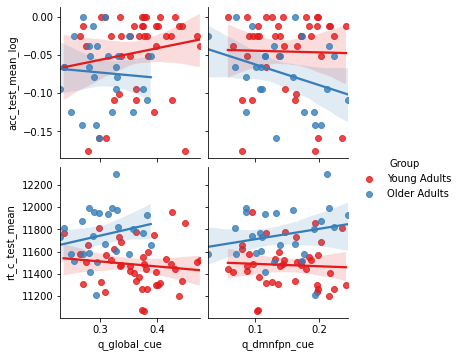

In [99]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if not 'power' in v and 'cue' in v]
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=modVars_, hue='Group', kind='reg')

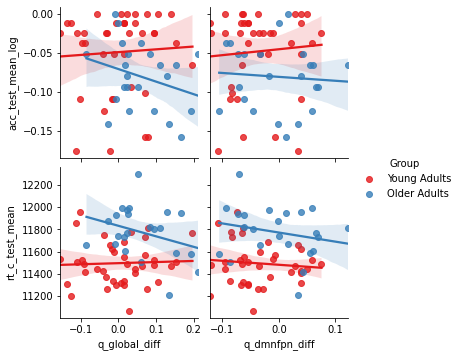

In [100]:
sns.set_palette('Set1')
modVars_ = [v for v in modVars if 'diff' in v]
sns.pairplot(data=df, x_vars=modVars_, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], hue='Group', kind='reg')

### Participation coefficient

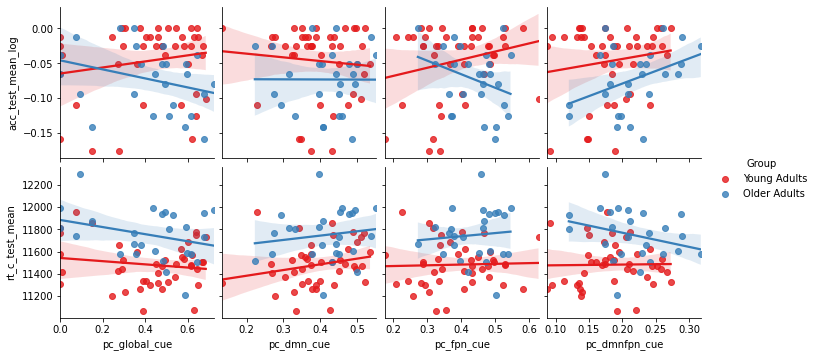

In [101]:
sns.set_palette('Set1')
pcVars_ = [v for v in pcVars if 'cue' in v and not 'power' in v]
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], x_vars=pcVars_, hue='Group', kind='reg')

### Mean FC

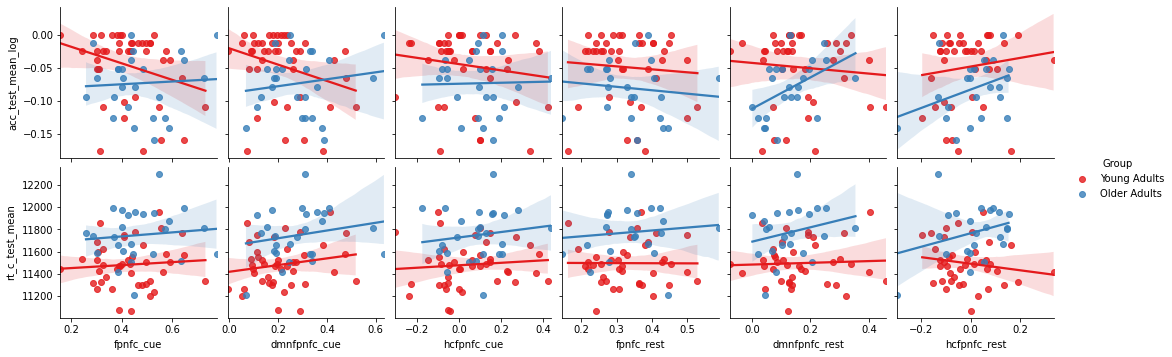

In [102]:
sns.set_palette('Set1')
fcVars_ = [v for v in fcVars if 'fpnfc_cue' in v or 'fpnfc_rest' in v]
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], 
             x_vars=fcVars_, hue='Group', kind='reg')

<AxesSubplot:xlabel='condition', ylabel='dmnfpnfc'>

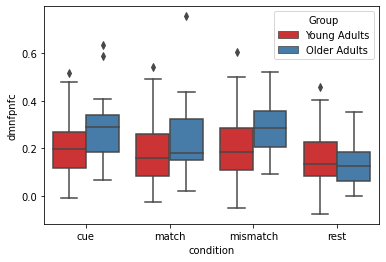

In [103]:
dfl = df.reset_index()[['subject', 'Group'] + fcVars]
dfl = pd.wide_to_long(dfl, ["dmnfpnfc", "dmnfc", "fpnfc", "hcdmnfc", 'hcfpnfc'], i=['subject', 'Group'], j="condition", sep='_', suffix=r'\w+')
dfl = dfl.reset_index()
dfl.head()

sns.boxplot(data=dfl, x='condition', y='dmnfpnfc', hue='Group')

In [104]:
df.groupby('Group')[[v for v in fcVars if '_cue' in v or '_rest' in v]].mean()

,dmnfc_cue,fpnfc_cue,dmnfpnfc_cue,hcdmnfc_cue,hcfpnfc_cue,dmnfc_rest,fpnfc_rest,dmnfpnfc_rest,hcdmnfc_rest,hcfpnfc_rest
Group,,,,,,,,,,
Older Adults,0.362,0.471,0.284,0.132,0.089,0.316,0.340,0.131,0.044,0.014
Young Adults,0.331,0.428,0.212,0.144,0.047,0.354,0.331,0.164,0.043,-0.018


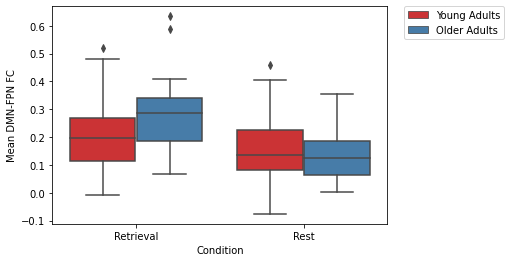

In [105]:
ax = sns.boxplot(data=dfl[dfl['condition'].isin(['cue', 'rest'])], x='condition', y='dmnfpnfc', hue='Group')
plt.ylabel('Mean DMN-FPN FC'), plt.xlabel('Condition')
ax.set_xticklabels(['Retrieval', 'Rest'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('results/dmnfpnfc_cond.png', dpi=300, bbox_inches='tight')

In [106]:
stats.ttest_ind(df[df['Group'] == 'Young Adults']['dmnfpnfc_cue'].dropna(),
               df[df['Group'] == 'Older Adults']['dmnfpnfc_cue'].dropna())

Ttest_indResult(statistic=-2.2789881057966874, pvalue=0.025860029373125683)

In [107]:
stats.ttest_ind(df[df['Group'] == 'Young Adults']['hcfpnfc_rest'].dropna(),
               df[df['Group'] == 'Older Adults']['hcfpnfc_rest'].dropna())

Ttest_indResult(statistic=-1.1204224958813827, pvalue=0.2669256637333154)

In [108]:
stats.ttest_ind(df[df['Group'] == 'Older Adults']['dmnfpnfc_rest'].dropna(),
               df[df['Group'] == 'Older Adults']['dmnfpnfc_cue'].dropna())

Ttest_indResult(statistic=-4.681787810290464, pvalue=2.4452263926574716e-05)

In [109]:
reldf = df[~df['hcdmnfc_rest'].isna()]
reldf = reldf[~reldf['hcdmnfc_cue'].isna()]
print(reldf[reldf['Group'] == 'Older Adults'].shape)

stats.ttest_rel(reldf['hcdmnfc_rest'],
               reldf['hcdmnfc_cue'])

(23, 107)


Ttest_relResult(statistic=-4.359902724572449, pvalue=4.9949570354985625e-05)

In [110]:
stats.ttest_ind(df[df['Group'] == 'Young Adults']['dmnfpnfc_rest'].dropna(),
               df[df['Group'] == 'Young Adults']['dmnfpnfc_cue'].dropna())

Ttest_indResult(statistic=-1.7743489162605184, pvalue=0.07976300623887243)

In [111]:
stats.ttest_rel(reldf[reldf['Group'] == 'Young Adults']['dmnfpnfc_rest'],
               reldf[reldf['Group'] == 'Young Adults']['dmnfpnfc_cue'])

Ttest_relResult(statistic=-2.4101588741153623, pvalue=0.02076079562449603)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

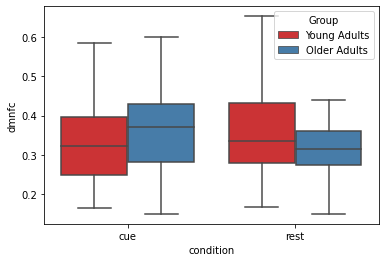

In [112]:
sns.boxplot(data=dfl[dfl['condition'].isin(['cue', 'rest'])], x='condition', y='dmnfc', hue='Group')
plt.xlabel

<AxesSubplot:xlabel='condition', ylabel='fpnfc'>

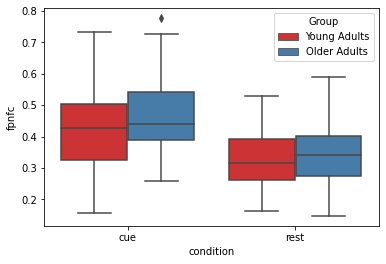

In [113]:
sns.boxplot(data=dfl[dfl['condition'].isin(['cue', 'rest'])], x='condition', y='fpnfc', hue='Group')

<AxesSubplot:xlabel='condition', ylabel='hcfpnfc'>

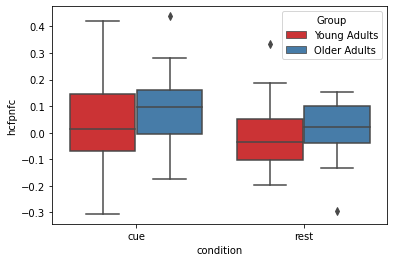

In [114]:
sns.boxplot(data=dfl[dfl['condition'].isin(['cue', 'rest'])], x='condition', y='hcfpnfc', hue='Group')

<AxesSubplot:xlabel='condition', ylabel='hcdmnfc'>

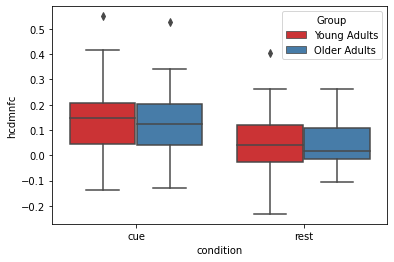

In [115]:
sns.boxplot(data=dfl[dfl['condition'].isin(['cue', 'rest'])], x='condition', y='hcdmnfc', hue='Group')

In [116]:
stats.ttest_ind(df[df['Group'] == 'Older Adults']['dmnfc_rest'].dropna(),
               df[df['Group'] == 'Older Adults']['dmnfc_cue'].dropna())

Ttest_indResult(statistic=-1.7142211321470786, pvalue=0.0930765338031683)

In [117]:
stats.ttest_ind(df[df['Group'] == 'Young Adults']['dmnfc_rest'].dropna(),
               df[df['Group'] == 'Young Adults']['dmnfc_cue'].dropna())

Ttest_indResult(statistic=0.9806377056495434, pvalue=0.32969140008265063)

In [118]:
stats.ttest_ind(df['dmnfc_rest'].dropna(),
               df['dmnfc_cue'].dropna())

Ttest_indResult(statistic=-0.13712413246560431, pvalue=0.8911448216137543)

### NBS Edge Strength

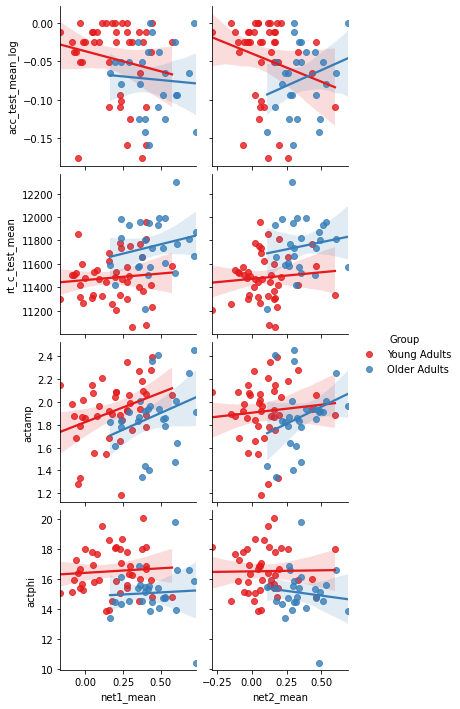

In [119]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean', 'actamp', 'actphi'], 
             x_vars=['net1_mean', 'net2_mean'], hue='Group', kind='reg')

## Exploratory 

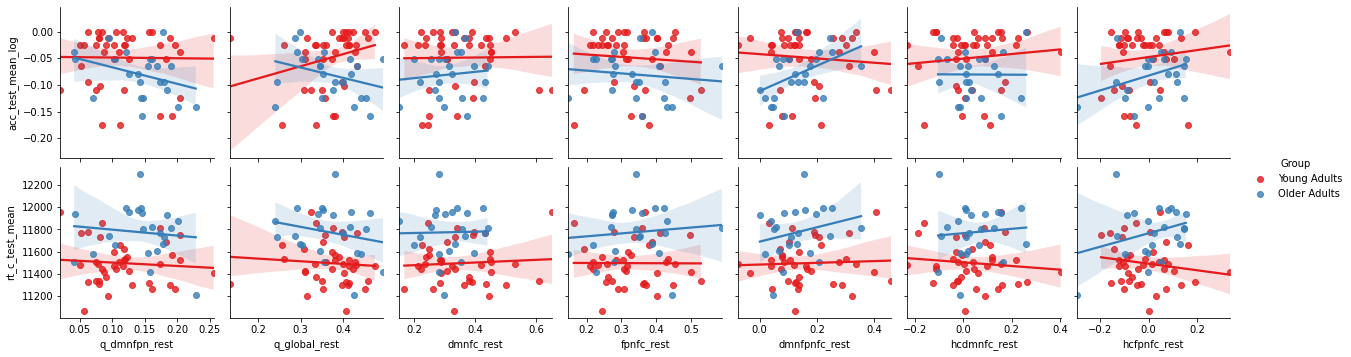

In [120]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'], 
             x_vars=[v for v in df.columns if '_rest' in v], hue='Group', kind='reg')

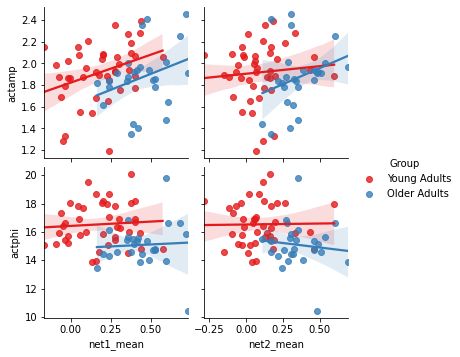

In [121]:
sns.set_palette('Set1')
sns.pairplot(data=df, y_vars=['actamp', 'actphi'], 
             x_vars=['net1_mean', 'net2_mean'], hue='Group', kind='reg')

In [122]:
regVars = ['rt_c_test_mean', 'net1_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net1_mean'].abs() > 3]))
regdf = regdf[regdf['net1_mean'].abs() < 3]
smf.ols(formula='rt_c_test_mean ~ net1_mean + Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     13.51
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           1.21e-05
Time:                        13:51:33   Log-Likelihood:                -86.066
No. Observations:                  69   AIC:                             178.1
Df Residuals:                      66   BIC:                             184.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5597      0.197      2.842      0.006       0.167       0.953
Group[T.Young Adults]    -0.8981      0.269     -3.343      0.001      -1.434      -0.362
net1_mean                 0.1496      0.130      1.149      0.255      -0.110       0.409
==============================================================================
Omnibus:                        0.136   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.001
Skew:                           0.007   Prob(JB):                         1.00
Kurtosis:                       2.998   Cond. No.                         3.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
regVars = ['acc_test_mean', 'net2_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['net2_mean'].abs() < 3]
smf.ols(formula='acc_test_mean ~ net2_mean * Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acc_test_mean   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.222
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0283
Time:                        13:51:33   Log-Likelihood:                -93.124
No. Observations:                  69   AIC:                             194.2
Df Residuals:                      65   BIC:                             203.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.6181      0.295     -2.098      0.040      -1.206      -0.030
Group[T.Young Adults]               0.6825      0.341      2.001      0.050       0.001       1.364
net2_mean                           0.3239      0.275      1.179      0.243      -0.225       0.872
net2_mean:Group[T.Young Adults]    -0.6206      0.329     -1.889      0.063      -1.277       0.036
==============================================================================
Omnibus:                        8.074   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.293
Skew:                          -0.849   Prob(JB):                       0.0158
Kurtosis:                       2.994   Cond. No.                         6.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
regVars = ['rt_c_test_mean', 'net2_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['net2_mean'].abs() < 3]
smf.ols(formula='rt_c_test_mean ~ net2_mean + Group', data=regdf).fit().summary()


0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     13.17
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           1.54e-05
Time:                        13:51:33   Log-Likelihood:                -86.323
No. Observations:                  69   AIC:                             178.6
Df Residuals:                      66   BIC:                             185.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5749      0.203      2.831      0.006       0.169       0.980
Group[T.Young Adults]    -0.9225      0.280     -3.297      0.002      -1.481      -0.364
net2_mean                 0.1227      0.136      0.905      0.369      -0.148       0.393
==============================================================================
Omnibus:                        0.436   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.804   Jarque-Bera (JB):                0.244
Skew:                           0.146   Prob(JB):                        0.885
Kurtosis:                       3.008   Cond. No.                         4.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
regVars = ['net1_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['net1_mean'].abs() > 3]))

smf.ols(formula='net1_mean ~ actamp + Group', data=regdf).fit().summary()

0
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net1_mean   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     25.47
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           6.35e-09
Time:                        13:51:34   Log-Likelihood:                -78.173
No. Observations:                  69   AIC:                             162.3
Df Residuals:                      66   BIC:                             169.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.8066      0.151      5.342      0.000       0.505       1.108
Group[T.Young Adults]    -1.2943      0.192     -6.758      0.000      -1.677      -0.912
actamp                    0.2652      0.093      2.858      0.006       0.080       0.450
==============================================================================
Omnibus:                        1.352   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.154
Skew:                          -0.120   Prob(JB):                        0.562
Kurtosis:                       2.414   Cond. No.                         3.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
regVars = ['net1_mean', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actphi'].abs() > 3]))
print(len(regdf[regdf['net1_mean'].abs() > 3]))
regdf = regdf[regdf['actphi'].abs() < 3]
regdf = regdf[regdf['net1_mean'].abs() < 3]

smf.ols(formula='net1_mean ~ actphi', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

1
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net1_mean   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     3.976
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0581
Time:                        13:51:34   Log-Likelihood:                -23.941
No. Observations:                  25   AIC:                             51.88
Df Residuals:                      23   BIC:                             54.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8696      0.151      5.763      0.000       0.557       1.182
actphi         0.3415      0.171      1.994      0.058      -0.013       0.696
==============================================================================
Omnibus:                        0.895   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.778
Skew:                           0.123   Prob(JB):                        0.678
Kurtosis:                       2.171   Cond. No.                         1.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
regVars = ['net2_mean', 'actamp']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
print(len(regdf[regdf['actamp'].abs() > 3]))
print(len(regdf[regdf['net2_mean'].abs() > 3]))
regdf = regdf[regdf['actamp'].abs() < 3]
regdf = regdf[regdf['net2_mean'].abs() < 3]

smf.ols(formula='net2_mean ~ actamp', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

0
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net2_mean   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.178
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.153
Time:                        13:51:34   Log-Likelihood:                -25.988
No. Observations:                  26   AIC:                             55.98
Df Residuals:                      24   BIC:                             58.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8449      0.135      6.262      0.000       0.566       1.123
actamp         0.1907      0.129      1.476      0.153      -0.076       0.457
==============================================================================
Omnibus:                        0.770   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.681   Jarque-Bera (JB):                0.556
Skew:                           0.343   Prob(JB):                        0.757
Kurtosis:                       2.794   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
df[['acc_test_mean', 'rt_c_test_mean'] + fcVars].corr()

,acc_test_mean,rt_c_test_mean,dmnfc_cue,fpnfc_cue,dmnfpnfc_cue,hcdmnfc_cue,hcfpnfc_cue,dmnfc_match,fpnfc_match,dmnfpnfc_match,...,dmnfc_mismatch,fpnfc_mismatch,dmnfpnfc_mismatch,hcdmnfc_mismatch,hcfpnfc_mismatch,dmnfc_rest,fpnfc_rest,dmnfpnfc_rest,hcdmnfc_rest,hcfpnfc_rest
acc_test_mean,1.000,-5.646e-01,-0.274,-0.196,-0.197,-7.615e-02,-0.131,-0.130,-0.246,-0.226,...,-0.016,-0.284,-0.214,-0.246,-0.420,0.078,-0.101,0.083,0.072,0.148
rt_c_test_mean,-0.565,1.000e+00,0.312,0.163,0.298,-7.978e-04,0.160,0.187,0.239,0.320,...,0.092,0.340,0.304,0.379,0.454,-0.060,0.060,0.010,-0.031,0.095
dmnfc_cue,-0.274,3.123e-01,1.000,0.726,0.886,3.901e-01,0.302,0.565,0.454,0.644,...,0.415,0.497,0.513,0.227,0.317,0.307,0.347,0.474,0.137,0.283
fpnfc_cue,-0.196,1.627e-01,0.726,1.000,0.771,4.052e-01,0.284,0.478,0.520,0.537,...,0.386,0.490,0.537,0.302,0.327,0.272,0.396,0.364,0.124,0.023
dmnfpnfc_cue,-0.197,2.980e-01,0.886,0.771,1.000,3.752e-01,0.343,0.475,0.421,0.643,...,0.410,0.424,0.596,0.251,0.255,0.321,0.351,0.503,0.208,0.289
hcdmnfc_cue,-0.076,-7.978e-04,0.390,0.405,0.375,1.000e+00,0.721,0.076,0.225,0.214,...,0.030,0.132,0.164,-0.018,0.159,0.168,0.386,0.267,0.133,0.187
hcfpnfc_cue,-0.131,1.596e-01,0.302,0.284,0.343,7.206e-01,1.000,0.021,0.177,0.149,...,-0.043,0.086,0.108,-0.005,0.215,0.044,0.303,0.127,0.025,0.115
dmnfc_match,-0.130,1.873e-01,0.565,0.478,0.475,7.583e-02,0.021,1.000,0.660,0.831,...,0.550,0.633,0.543,0.197,0.227,0.119,0.117,0.183,-0.006,0.041
fpnfc_match,-0.246,2.393e-01,0.454,0.520,0.421,2.248e-01,0.177,0.660,1.000,0.802,...,0.417,0.620,0.547,0.297,0.352,0.105,0.150,0.183,-0.035,-0.075
dmnfpnfc_match,-0.226,3.197e-01,0.644,0.537,0.643,2.137e-01,0.149,0.831,0.802,1.000,...,0.559,0.654,0.700,0.292,0.314,0.212,0.263,0.346,0.010,0.170


## RAR - Brain Associations

Int64Index([40656], dtype='int64', name='subject')


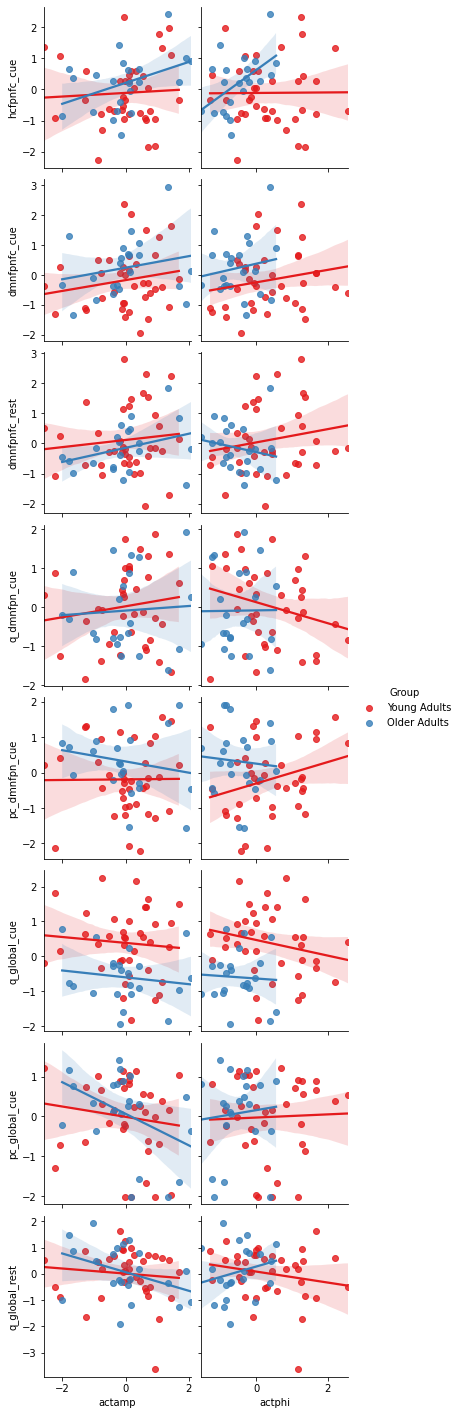

In [129]:
regVars = ['actamp', 'actphi', 'hcfpnfc_cue', 'dmnfpnfc_cue', 'dmnfpnfc_rest', 'q_dmnfpn_cue', 'pc_dmnfpn_cue', 'q_global_cue', 'pc_global_cue', 'q_global_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(regdf[regdf['actphi'].abs() > 3].index)

regdf = regdf[regdf['actphi'].abs() < 3]
regdf = regdf[regdf['actamp'].abs() < 3]

sns.set_palette('Set1')
sns.pairplot(data=regdf, x_vars=['actamp', 'actphi'],
             y_vars=['hcfpnfc_cue', 'dmnfpnfc_cue', 'dmnfpnfc_rest', 'q_dmnfpn_cue', 'pc_dmnfpn_cue', 'q_global_cue', 'pc_global_cue', 'q_global_rest'], hue='Group', kind='reg')

In [130]:
regdf.corr()[['actamp', 'actphi']]

,actamp,actphi
actamp,1.000,0.107
actphi,0.107,1.000
hcfpnfc_cue,0.170,0.037
dmnfpnfc_cue,0.183,0.064
dmnfpnfc_rest,0.172,0.158
q_dmnfpn_cue,0.109,-0.130
pc_dmnfpn_cue,-0.067,0.043
q_global_cue,-0.079,0.084
pc_global_cue,-0.245,0.021
q_global_rest,-0.212,-0.091


In [131]:
smf.ols(formula='pc_global_cue ~ actamp + Group', 
        data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pc_global_cue   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.867
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.164
Time:                        13:51:48   Log-Likelihood:                -82.845
No. Observations:                  60   AIC:                             171.7
Df Residuals:                      57   BIC:                             178.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0718      0.211      0.341      0.735      -0.350       0.493
Group[T.Young Adults]    -0.0790      0.265     -0.299      0.766      -0.609       0.451
actamp                   -0.2404      0.126     -1.900      0.062      -0.494       0.013
==============================================================================
Omnibus:                        6.486   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.383
Skew:                          -0.750   Prob(JB):                       0.0411
Kurtosis:                       2.448   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
smf.ols(formula='q_global_rest ~ actamp + Group', 
        data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.363
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.264
Time:                        13:51:48   Log-Likelihood:                -82.210
No. Observations:                  60   AIC:                             170.4
Df Residuals:                      57   BIC:                             176.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0695      0.208      0.333      0.740      -0.348       0.487
Group[T.Young Adults]    -0.0580      0.262     -0.222      0.825      -0.582       0.466
actamp                   -0.2040      0.125     -1.630      0.109      -0.455       0.047
==============================================================================
Omnibus:                       13.297   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.876
Skew:                          -0.967   Prob(JB):                     0.000589
Kurtosis:                       4.487   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
smf.ols(formula='hcfpnfc_cue ~ actamp * Group', 
        data=regdf).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hcfpnfc_cue   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.432
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.243
Time:                        13:51:48   Log-Likelihood:                -83.372
No. Observations:                  60   AIC:                             174.7
Df Residuals:                      56   BIC:                             183.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.2140      0.214      0.998      0.323      -0.216       0.643
Group[T.Young Adults]           -0.3241      0.269     -1.203      0.234      -0.864       0.216
actamp                           0.3369      0.200      1.686      0.097      -0.063       0.737
actamp:Group[T.Young Adults]    -0.2782      0.261     -1.065      0.291      -0.802       0.245
==============================================================================
Omnibus:                        1.064   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                0.986
Skew:                           0.301   Prob(JB):                        0.611
Kurtosis:                       2.822   Cond. No.                         3.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
smf.ols(formula='hcfpnfc_cue ~ actamp', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hcfpnfc_cue   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     4.008
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0590
Time:                        13:51:48   Log-Likelihood:                -26.498
No. Observations:                  22   AIC:                             57.00
Df Residuals:                      20   BIC:                             59.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2140      0.181      1.185      0.250      -0.163       0.591
actamp         0.3369      0.168      2.002      0.059      -0.014       0.688
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.217
Skew:                           0.176   Prob(JB):                        0.897
Kurtosis:                       2.664   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
smf.ols(formula='hcfpnfc_cue ~ actphi * Group', 
        data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hcfpnfc_cue   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.046
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.118
Time:                        13:51:48   Log-Likelihood:                -82.468
No. Observations:                  60   AIC:                             172.9
Df Residuals:                      56   BIC:                             181.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6243      0.286      2.179      0.034       0.050       1.198
Group[T.Young Adults]           -0.7365      0.335     -2.197      0.032      -1.408      -0.065
actphi                           0.8366      0.383      2.183      0.033       0.069       1.605
actphi:Group[T.Young Adults]    -0.8282      0.422     -1.964      0.055      -1.673       0.017
==============================================================================
Omnibus:                        1.637   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.441   Jarque-Bera (JB):                1.339
Skew:                           0.365   Prob(JB):                        0.512
Kurtosis:                       2.954   Cond. No.                         6.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
smf.ols(formula='hcfpnfc_cue ~ actphi', 
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hcfpnfc_cue   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     7.455
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0129
Time:                        13:51:48   Log-Likelihood:                -25.023
No. Observations:                  22   AIC:                             54.05
Df Residuals:                      20   BIC:                             56.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6243      0.229      2.726      0.013       0.147       1.102
actphi         0.8366      0.306      2.730      0.013       0.197       1.476
==============================================================================
Omnibus:                        1.254   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                0.760
Skew:                           0.452   Prob(JB):                        0.684
Kurtosis:                       2.888   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

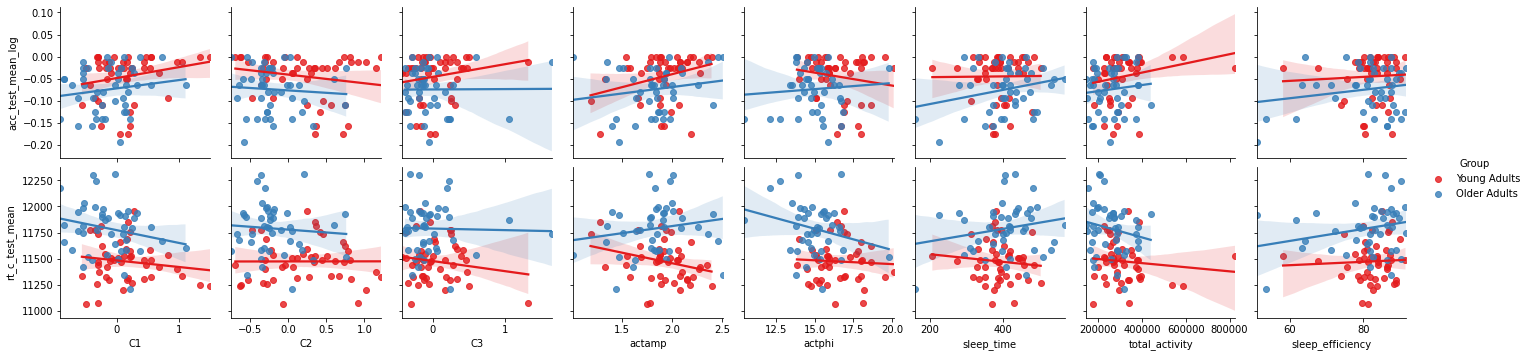

In [137]:
sns.pairplot(data=df, y_vars=['acc_test_mean_log', 'rt_c_test_mean'],
            x_vars=pcaVars + sleepVars, hue='Group', kind='reg')

In [138]:
regVars = ['rt_c_test_mean', 'actphi']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='rt_c_test_mean ~ actphi',
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.673
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.110
Time:                        13:52:02   Log-Likelihood:                -54.849
No. Observations:                  43   AIC:                             113.7
Df Residuals:                      41   BIC:                             117.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4906      0.154      3.182      0.003       0.179       0.802
actphi        -0.2473      0.151     -1.635      0.110      -0.553       0.058
==============================================================================
Omnibus:                        0.639   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.111
Skew:                          -0.025   Prob(JB):                        0.946
Kurtosis:                       3.243   Cond. No.                         1.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
regVars = ['acc_test_mean_log', 'sleep_time']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ sleep_time',
        data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.018
Date:                Fri, 11 Mar 2022   Prob (F-statistic):             0.0895
Time:                        13:52:02   Log-Likelihood:                -60.088
No. Observations:                  45   AIC:                             124.2
Df Residuals:                      43   BIC:                             127.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3154      0.141     -2.235      0.031      -0.600      -0.031
sleep_time     0.2102      0.121      1.737      0.090      -0.034       0.454
==============================================================================
Omnibus:                        2.975   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                1.523
Skew:                          -0.034   Prob(JB):                        0.467
Kurtosis:                       2.101   Cond. No.                         1.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Mediation

In [140]:
regVars = ['actphi', 'pc_global_cue', 'acc_test_mean_log']
regdf = df[['GroupBin', 'sex'] + regVars].dropna()[['GroupBin', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

print(len(regdf[regdf['pc_global_cue'].abs() > 3]))
regdf = regdf[regdf['pc_global_cue'].abs() < 3]

medtab = pg.mediation_analysis(data=regdf[regdf['GroupBin'] == 1], 
                               x='actphi', 
                               m='pc_global_cue', 
                               y='acc_test_mean_log',
                               alpha=0.05)
medtab.to_latex('./results/mediation_tab1.tex')
medtab

0


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,pc_global_cue ~ X,0.262,0.209,0.222,-0.169,0.693,No
1,Y ~ pc_global_cue,-0.268,0.172,0.132,-0.622,0.087,No
2,Total,0.152,0.188,0.427,-0.236,0.539,No
3,Direct,0.236,0.185,0.213,-0.146,0.618,No
4,Indirect,-0.085,0.116,0.232,-0.350,0.073,No


## Plots

In [141]:
plt.rcParams.update({'font.size': 12})

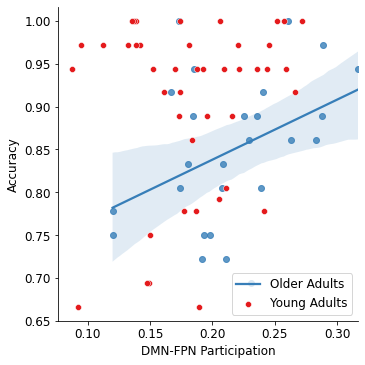

In [142]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='pc_dmnfpn_cue', y='acc_test_mean', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='pc_dmnfpn_cue', y='acc_test_mean', color =sns.color_palette('Set1')[0], label = 'Young Adults')
plt.ylabel('Accuracy'); plt.xlabel('DMN-FPN Participation'); plt.legend()
plt.savefig('./results/pcDF_acc.png', dpi=300, bbox_inches='tight')


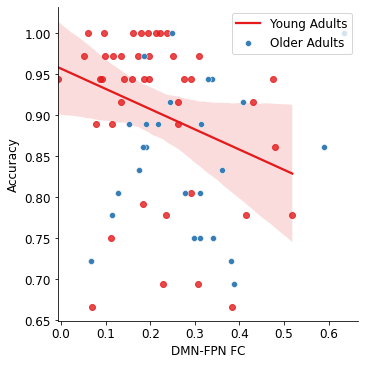

In [143]:
sns.lmplot(data=df[df['Group'] == 'Young Adults'], x='dmnfpnfc_cue', y='acc_test_mean', scatter_kws={'color': sns.color_palette('Set1')[0]}, line_kws={'label': 'Young Adults', 'color': sns.color_palette('Set1')[0]})
sns.scatterplot(data=df[df['Group'] == 'Older Adults'], x='dmnfpnfc_cue', y='acc_test_mean', color =sns.color_palette('Set1')[1], label = 'Older Adults')
plt.ylabel('Accuracy'); plt.xlabel('DMN-FPN FC')
plt.legend(loc='upper right')
plt.savefig('./results/dmnfpn_acc.png', dpi=300, bbox_inches='tight')

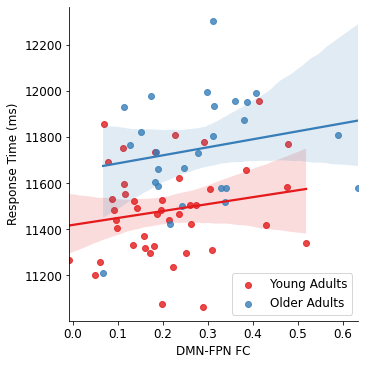

In [144]:
sns.lmplot(data=df, x='dmnfpnfc_cue', y='rt_c_test_mean', hue='Group', legend=False)
plt.ylabel('Response Time (ms)'); plt.xlabel('DMN-FPN FC')
plt.legend(loc='lower right')
plt.savefig('./results/dmnfpn_rtc.png', dpi=300, bbox_inches='tight')

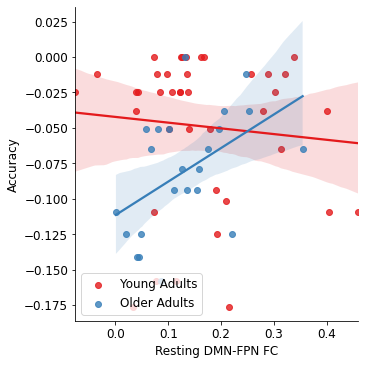

In [145]:
sns.lmplot(data=df, x='dmnfpnfc_rest', y='acc_test_mean_log', hue='Group', legend=False)
plt.ylabel('Accuracy'); plt.xlabel('Resting DMN-FPN FC')
plt.legend(loc='lower left')
plt.savefig('./results/dmnfpnfcrest_acc.png', dpi=300, bbox_inches='tight')

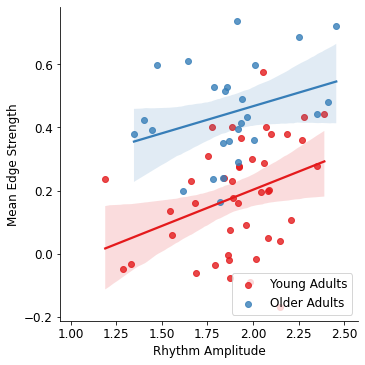

In [146]:
sns.lmplot(data=df, x='actamp', y='net1_mean', hue='Group', legend=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Mean Edge Strength')
plt.legend(loc='lower right')
plt.savefig('./results/amp_net1.png', dpi=300, bbox_inches='tight')

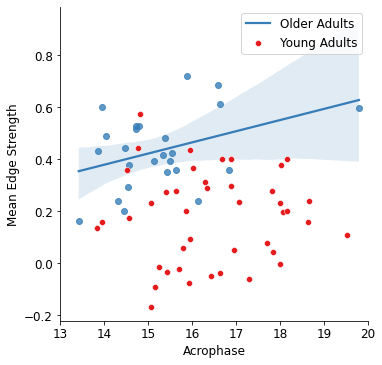

In [147]:
df_ = df.drop(index=40656)
sns.lmplot(data=df_[df_['Group'] == 'Older Adults'], x='actphi', y='net1_mean', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df_[df_['Group'] == 'Young Adults'], x='actphi', y='net1_mean', color =sns.color_palette('Set1')[0], label = 'Young Adults')
plt.xlabel('Acrophase'); plt.ylabel('Mean Edge Strength'); plt.legend(); plt.xlim((13,20))
plt.savefig('./results/phi_net1.png', dpi=300, bbox_inches='tight')

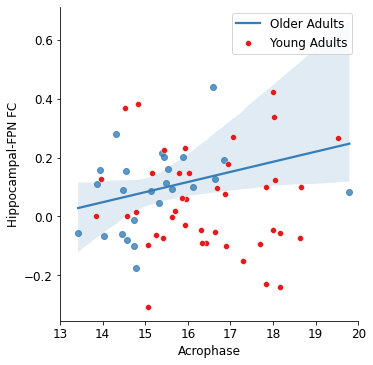

In [148]:
df_ = df.drop(index=40656)
sns.lmplot(data=df_[df_['Group'] == 'Older Adults'], x='actphi', y='hcfpnfc_cue', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df_[df_['Group'] == 'Young Adults'], x='actphi', y='hcfpnfc_cue', color =sns.color_palette('Set1')[0], label = 'Young Adults')
plt.xlabel('Acrophase'); plt.ylabel('Hippocampal-FPN FC'); plt.legend(); plt.xlim((13,20))
plt.savefig('./results/phi_hcfpnfc.png', dpi=300, bbox_inches='tight')

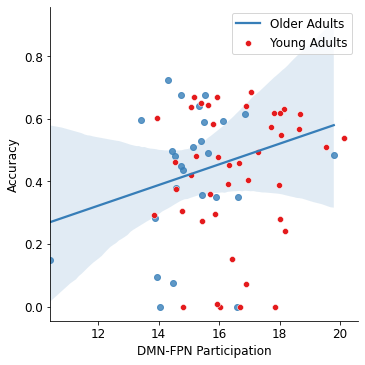

In [149]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actphi', y='pc_global_cue', scatter_kws={'color': sns.color_palette('Set1')[1]}, line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='actphi', y='pc_global_cue', color =sns.color_palette('Set1')[0], label = 'Young Adults')
plt.ylabel('Accuracy'); plt.xlabel('DMN-FPN Participation'); plt.legend()
plt.savefig('./results/pcDF_acc.png', dpi=300, bbox_inches='tight')



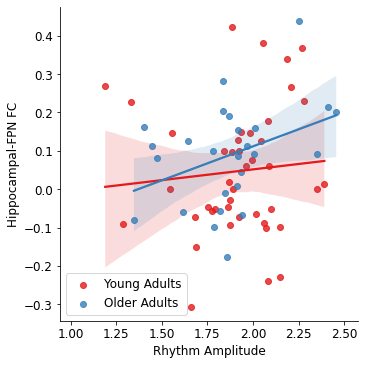

In [150]:
sns.lmplot(data=df, x='actamp', y='hcfpnfc_cue', hue='Group', legend=False)
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.legend(loc='lower left')
plt.savefig('./results/amp_hcfpnfc.png', dpi=300, bbox_inches='tight')

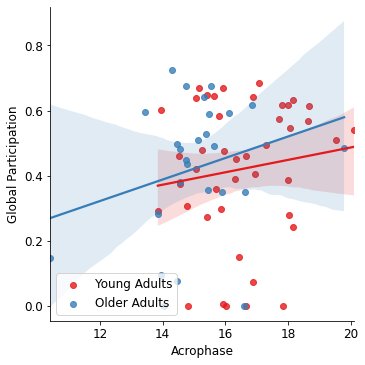

In [151]:
sns.lmplot(data=df, x='actphi', y='pc_global_cue', hue='Group', legend=False)
plt.xlabel('Acrophase'); plt.ylabel('Global Participation')
plt.legend(loc='lower left');
plt.savefig('./results/phi_pcglobalcue.png', dpi=300, bbox_inches='tight')

In [152]:
sns.color_palette('Set1')[1]

(0.21568627450980393, 0.49411764705882355, 0.7215686274509804)

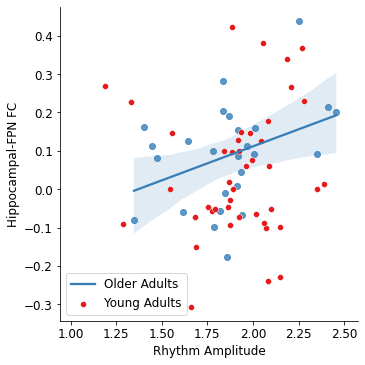

In [153]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='hcfpnfc_cue', 
           scatter_kws={'color': sns.color_palette('Set1')[1]}, 
           line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='actamp', y='hcfpnfc_cue', 
                color =sns.color_palette('Set1')[0], label = 'Young Adults')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-FPN FC')
plt.legend(loc='lower left')
plt.savefig('./results/amp_hcfpnfc.png', dpi=300, bbox_inches='tight')

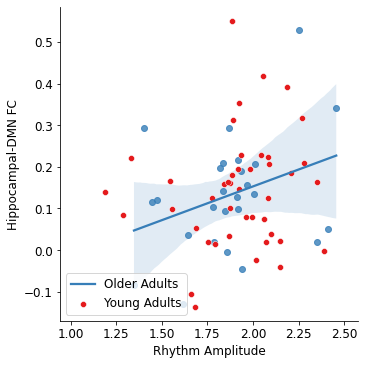

In [154]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='hcdmnfc_cue', 
           scatter_kws={'color': sns.color_palette('Set1')[1]}, 
           line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], x='actamp', y='hcdmnfc_cue', 
                color =sns.color_palette('Set1')[0], label = 'Young Adults')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Hippocampal-DMN FC')
plt.legend(loc='lower left')
plt.savefig('./results/amp_hcdmnfc.png', dpi=300, bbox_inches='tight')

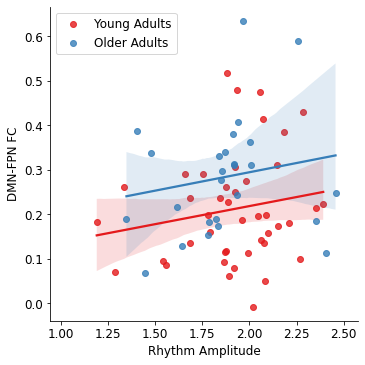

In [155]:

sns.lmplot(data=df, x='actamp', y='dmnfpnfc_cue', hue='Group', legend=False)
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('DMN-FPN FC')
plt.legend(loc='upper left')
plt.savefig('./results/amp_dmnfpnfc.png', dpi=300, bbox_inches='tight')

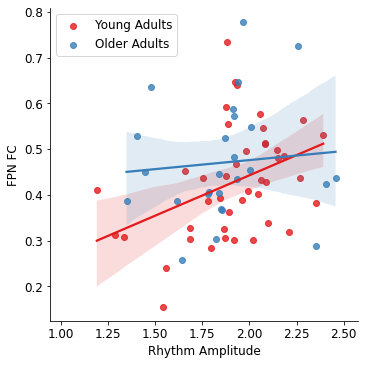

In [156]:

sns.lmplot(data=df, x='actamp', y='fpnfc_cue', hue='Group', legend=False)
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('FPN FC')
plt.legend(loc='upper left')
plt.savefig('./results/amp_fpnfc.png', dpi=300, bbox_inches='tight')

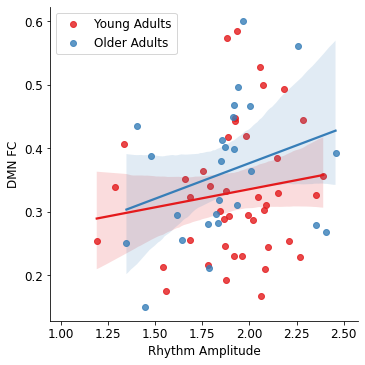

In [157]:

sns.lmplot(data=df, x='actamp', y='dmnfc_cue', hue='Group', legend=False)
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('DMN FC')
plt.legend(loc='upper left')
plt.savefig('./results/amp_dmnfc.png', dpi=300, bbox_inches='tight')

In [158]:
regVars = ['acc_test_mean_log', 'rt_c_test_mean', 'hcfpnfc_cue']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['hcfpnfc_cue'].abs() < 3]

smf.ols('acc_test_mean_log ~ hcfpnfc_cue',
              data=regdf[regdf['Group'] == 'Older Adults']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                   0.01176
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.915
Time:                        13:52:22   Log-Likelihood:                -33.437
No. Observations:                  26   AIC:                             70.87
Df Residuals:                      24   BIC:                             73.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.3337      0.182     -1.832      0.079      -0.710       0.042
hcfpnfc_cue     0.0230      0.212      0.108      0.915      -0.415       0.461
==============================================================================
Omnibus:                        1.759   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.110
Skew:                          -0.173   Prob(JB):                        0.574
Kurtosis:                       2.048   Cond. No.                         1.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

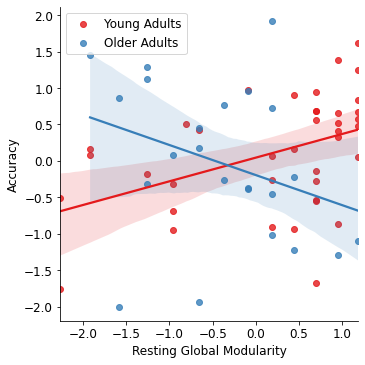

In [159]:
regVars = ['acc_test_mean_log', 'rt_c_test_mean', 'q_global_rest', 'dmnfpnfc_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols('acc_test_mean_log ~ Group * q_global_rest',
              data=regdf).fit().summary()

sns.lmplot(data=regdf, x='acc_test_mean_log', y='q_global_rest', hue='Group', legend=False)
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Resting Global Modularity'); plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('./results/qglobalrest_acc.png', dpi=300, bbox_inches='tight')

In [160]:
regVars = ['acc_test_mean_log', 'rt_c_test_mean', 'q_global_rest', 'dmnfpnfc_rest']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['dmnfpnfc_rest'].abs() < 3]

smf.ols('rt_c_test_mean ~ dmnfpnfc_rest * Group',
              data=regdf).fit().summary()

# sns.lmplot(data=regdf, x='acc_test_mean_log', y='q_global_rest', hue='Group')
# #           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
# plt.xlabel('Resting Global Modularity'); plt.ylabel('Accuracy')
# plt.legend(loc='upper left')
# plt.savefig('./results/qglobalrest_acc.png', dpi=300, bbox_inches='tight')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_test_mean   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     9.164
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           4.55e-05
Time:                        13:52:24   Log-Likelihood:                -77.344
No. Observations:                  63   AIC:                             162.7
Df Residuals:                      59   BIC:                             171.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.7759      0.183      4.233      0.000       0.409       1.143
Group[T.Young Adults]                  -1.1941      0.228     -5.237      0.000      -1.650      -0.738
dmnfpnfc_rest                           0.2868      0.228      1.258      0.213      -0.169       0.743
dmnfpnfc_rest:Group[T.Young Adults]    -0.2523      0.259     -0.973      0.335      -0.771       0.267
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.082
Skew:                           0.085   Prob(JB):                        0.960
Kurtosis:                       2.954   Cond. No.                         4.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

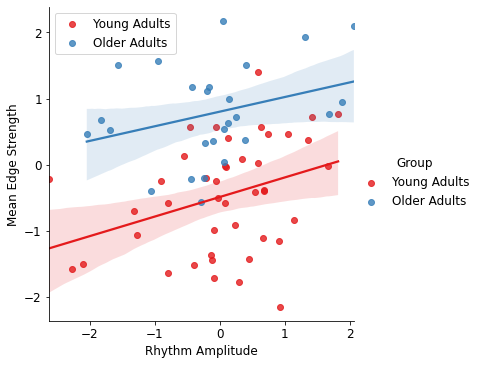

In [161]:
regVars = ['actamp', 'net1_mean']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['actamp'].abs() < 3]

sns.lmplot(data=regdf, x='actamp', y='net1_mean', hue='Group')
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Mean Edge Strength')
plt.legend(loc='upper left')
plt.savefig('./results/amp_net1mean.png', dpi=300, bbox_inches='tight')

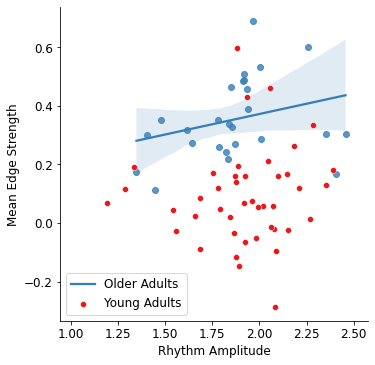

In [162]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='actamp', y='net2_mean', 
           scatter_kws={'color': sns.color_palette('Set1')[1]}, 
           line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], 
                x='actamp', y='net2_mean', 
                color =sns.color_palette('Set1')[0], label = 'Young Adults')
plt.xlabel('Rhythm Amplitude'); plt.ylabel('Mean Edge Strength')
plt.legend(loc='lower left')
plt.savefig('./results/amp_net2mean.png', dpi=300, bbox_inches='tight')

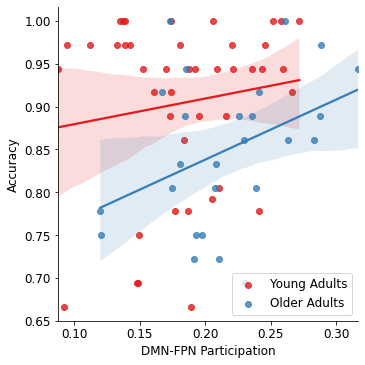

In [163]:
sns.lmplot(data=df, x='pc_dmnfpn_cue', y='acc_test_mean', hue='Group', legend=False)
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('DMN-FPN Participation'); plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('./results/pcdmnfpncue_acc.png', dpi=300, bbox_inches='tight')

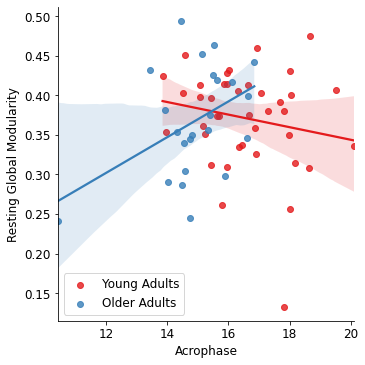

In [164]:
sns.lmplot(data=df, x='actphi', y='q_global_rest', hue='Group', legend=False)
#           scatter_kws={'color': 'black'}, line_kws={'color': 'black'})
plt.xlabel('Acrophase'); plt.ylabel('Resting Global Modularity')
plt.legend(loc='lower left')
plt.savefig('./results/phi_qglobalrest.png', dpi=300, bbox_inches='tight')

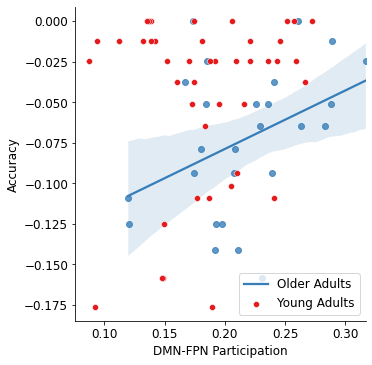

In [165]:
sns.lmplot(data=df[df['Group'] == 'Older Adults'], x='pc_dmnfpn_cue', y='acc_test_mean_log', 
           scatter_kws={'color': sns.color_palette('Set1')[1]}, 
           line_kws={'label': 'Older Adults', 'color': sns.color_palette('Set1')[1]})
sns.scatterplot(data=df[df['Group'] == 'Young Adults'], 
                x='pc_dmnfpn_cue', y='acc_test_mean_log', 
                color =sns.color_palette('Set1')[0],
               label = 'Young Adults')
plt.xlabel('DMN-FPN Participation'); plt.ylabel('Accuracy')
plt.savefig('./results/pcdmnfpncue_acc.png', dpi=300, bbox_inches='tight')

In [166]:
regVars = ['q_global_rest', 'actamp']

regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))
regdf = regdf[regdf['q_global_rest'].abs() < 3]

smf.ols(formula='q_global_rest ~ actamp', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          q_global_rest   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.426
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.237
Time:                        13:52:31   Log-Likelihood:                -80.189
No. Observations:                  62   AIC:                             164.4
Df Residuals:                      60   BIC:                             168.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0570      0.114      0.501      0.618      -0.171       0.285
actamp        -0.1358      0.114     -1.194      0.237      -0.363       0.092
==============================================================================
Omnibus:                        2.068   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.356   Jarque-Bera (JB):                2.035
Skew:                          -0.406   Prob(JB):                        0.361
Kurtosis:                       2.643   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
regVars = ['hcfpnfc_cue', 'acc_test_mean_log']
regdf = df[['Group', 'sex'] + regVars].dropna()[['Group', 'sex']].join(df[regVars].dropna().apply(stats.zscore))

smf.ols(formula='acc_test_mean_log ~ Group * hcfpnfc_cue', data=regdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_test_mean_log   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.914
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.136
Time:                        13:52:32   Log-Likelihood:                -94.986
No. Observations:                  69   AIC:                             198.0
Df Residuals:                      65   BIC:                             206.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.3337      0.197     -1.690      0.096      -0.728       0.061
Group[T.Young Adults]                 0.5185      0.249      2.084      0.041       0.022       1.015
hcfpnfc_cue                           0.0230      0.230      0.100      0.921      -0.436       0.482
Group[T.Young Adults]:hcfpnfc_cue    -0.1689      0.269     -0.627      0.533      -0.707       0.369
==============================================================================
Omnibus:                        9.680   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.192
Skew:                          -0.940   Prob(JB):                      0.00612
Kurtosis:                       3.097   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Old Plot Code

In [168]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats.mstats import zscore

# testvar = 'hcfpnfc_cue:Group[T.Young Adults]'
# plot_title = 'HC-FPN FC'
# x_pos = .5
# y_pos = -3.4

# model = smf.ols(formula='acc_test_mean_log ~ hcfpnfc_cue * Group', data=df[abs(df['hcfpnfc_cue']) < 3]).fit()
# summary = model.summary()

# #df = df.drop('40750')
# plt.figure(figsize=(8, 6), dpi=300, bbox_inches='tight')
# sns.lmplot(data=df[abs(df['hcfpnfc_cue']) < 3], x='hcfpnfc_cue', y="acc_test_mean_log", hue='Group', palette = 'Set1', legend_out=False)
# plt.ylabel('log(Accuracy)'); plt.xlabel('Mean HC-DMN FC')

# if model.pvalues[testvar] < 0.001:
#     plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
#     print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
# else:
#     plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
#     print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# # plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
# plt.savefig(results_dir + 'scatter-hc-dmn-fc_accuracy.png', dpi=300, bbox_inches='tight', bbox_inches="tight")

# summary